In [1]:
#hypothèses de travail : nous cherchons à créer un modèle de prédiction de RainTomorrow pour tout l'australie, qui s'adapte à tout changement climatique.
#Le premier travail sera de permettre de prédire la pluie demain à partir de variables explicatives pertinentes à sélectionner.


In [2]:
###import des bibliothèques
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import model_selection, preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn import metrics

In [3]:
#### Premier travail (rendu 8-7) : création du jeu de données pour modéliser

###chargement du fichier csv

df = pd.read_csv("svgd_données_brutes_projet.zip")
!pip install statsmodels==0.13.2
import statsmodels.api as sm
pd.set_option("display.max_rows", 200)#pour afficher toutes les colonnes (nombreuses au début)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 200)

###Première visualisation des contenus des variables et des types des variables:
display(df.head())
##conclusion : Nous remarquons des données de différents types et des manquantes à enlever.

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64


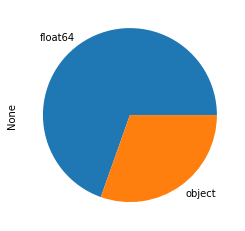

In [4]:
###Analyse des types des variables :

##pourcentage de valeurs en fonction de chaque type d'objets et de valeurs manquantes
df.dtypes.value_counts().plot.pie();
percent_missing_df = df.isnull().sum() * 100 / len(df)
print(percent_missing_df)
##conclusion : on remarque que nous avons un nombre conséquent de données, et donc de variables, de type
# catégorielles, qui ont un traitement différent et plus long que les variables quantitatives 
#(encodage).

In [5]:
print(len(df))

145460


In [6]:
###Premier filtre "Filre 1" des variables : Elimination des variables qui ont plus de 50% de manquantes :

print((100*df.isna().sum()/df.shape[0]).sort_values(ascending = False))

##Conclusion : aucune valeur  n'est au-dessus du seuil de rejet, donc aucune suppression sur 
#ce filtre.
#Mais nous remarquons les variables à fort taux de manquantes (supérieur 10%):
#Sunshine Evaporation
#Cloud 3am Cloud9am Pressure9am Pressure3pm

Sunshine         48.009762
Evaporation      43.166506
Cloud3pm         40.807095
Cloud9am         38.421559
Pressure9am      10.356799
Pressure3pm      10.331363
WindDir9am        7.263853
WindGustDir       7.098859
WindGustSpeed     7.055548
Humidity3pm       3.098446
WindDir3pm        2.906641
Temp3pm           2.481094
RainTomorrow      2.245978
Rainfall          2.241853
RainToday         2.241853
WindSpeed3pm      2.105046
Humidity9am       1.824557
Temp9am           1.214767
WindSpeed9am      1.214767
MinTemp           1.020899
MaxTemp           0.866905
Location          0.000000
Date              0.000000
dtype: float64


In [7]:
###Nettoyage des valeurs manquantes car on ne peut avoir de manquantes pour faire tourner
#la plupart des algorithmes nécessaires pour la suite: 

##Nettoyage des lignes qui ont une valeure manquante dans target : 

df = df.drop(df[df['RainTomorrow'].isna()].index, axis = 0)

##On vérifie la supression des lignes :
df.info()

##conclusion intermédiaire le nettoyage des valeurs manquantes sera et un choix sera à faire : 
#conserver des variables à fort taux de manquantes et supprimer des lignes ou conserver ces variables et remplacer les 
#manquantes ou enlever toutes les manquantes directement. 
#Ce choix sera fait en dernier 
#Le meilleur cas sera confirmé par l'évaluation des modèles.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [8]:
###Repérage et nettoyage des doublons
df = df.drop_duplicates()

##on vérifie les suppressions : 
print(df.info())

#conclusion : il n'y a pas de doublons.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

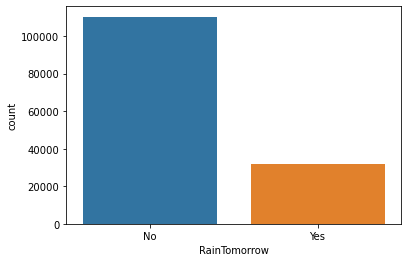

In [9]:
###Analyse de la répartition des valeurs dans les modalités de target ('RainTomorrow'):
sns.countplot(data = df, x = 'RainTomorrow');

 ##conclusion : environ 20% des valeurs sont dans la catégorie "" Yes" soit "il pleut aujourd'hui".
 #nous testerons l'effet d'un undersampling et comparerons l'évaluation des modèles
 # avec et sans pour décider enfin de la meilleure stratégie.

In [10]:
###Caractérisation globale de la symétrie des variables quantitatives, de leurs 'outliers'
#et repérage et Filtre 2 : nettoyage des variables constantes ou à variance très faible 

##Repérer les variances et filtre 1 : variables à trop faibles variances.
print(df.describe())
df.var()

#Conclusions de section :
#-aucune variable n'est à trop faible variance ou constante  donc on élimine pas de 
#variable par ces filtres.
#à ce stade.
#-Nous repérons des outliers sur certaines variables, à traiter ensuite si possible.

             MinTemp        MaxTemp       Rainfall   Evaporation  \
count  141556.000000  141871.000000  140787.000000  81350.000000   
mean       12.186400      23.226784       2.349974      5.469824   
std         6.403283       7.117618       8.465173      4.188537   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.800000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  74377.000000  132923.000000  140845.000000  139563.000000   
mean       7.624853      39.984292      14.001988      18.637576   
std        3.781525      13.588801       8.893337       8.803345   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.900000      31.000000       7.0000

C:\Users\rchaz\AppData\Local\Temp\ipykernel_79284\3151265855.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.var()


MinTemp           41.002029
MaxTemp           50.660488
Rainfall          71.659153
Evaporation       17.543838
Sunshine          14.299931
WindGustSpeed    184.655506
WindSpeed9am      79.091445
WindSpeed3pm      77.498884
Humidity9am      362.951747
Humidity3pm      432.547314
Pressure9am       50.487785
Pressure3pm       49.514820
Cloud9am           8.334859
Cloud3pm           7.401841
Temp9am           42.156950
Temp3pm           48.130209
dtype: float64

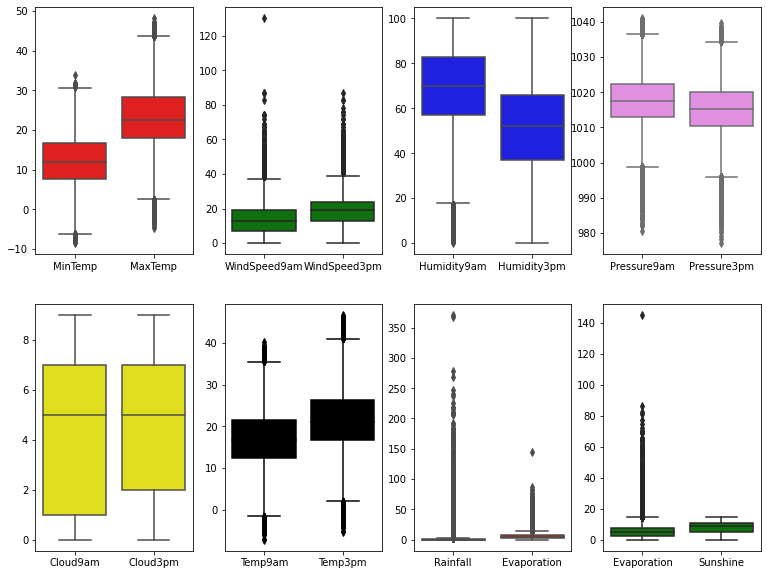

<Figure size 14400x14400 with 0 Axes>

In [11]:
###Caractérisation globale de la distribution des variables qualitatives

#création de sous dataframes
df_minmaxtemp = df.iloc[:, 2:4]
df_rainfall_evaporation = df.iloc[:, 4:6]
df_evaporation_sunshine = df.iloc[:, 5:7]
df_wind = df.iloc[:, 11:13]
df_humidity = df.iloc[:, 13:15]
df_pressure = df.iloc[:, 15:17]
df_cloud = df.iloc[:, 17:-4]
df_temp = df.iloc[:, 19:-2]

plt.figure(figsize = (13,10))
#Xf, axes = plt.subplots(4, 2)#6 graphiques (pour analyser les 6 catégorielles à part target "RainTomorrow" analysée séparément)
plt.subplot(2, 4, 1);
sns.boxplot(data=df_minmaxtemp, color="red")

plt.subplot(2, 4, 2)
sns.boxplot(data=df_wind, color="green")

plt.subplot(2, 4, 3)
sns.boxplot(data=df_humidity, color="blue")

plt.subplot(2, 4, 4)
sns.boxplot(data=df_pressure,  color="violet")

plt.subplot(2, 4, 5)
sns.boxplot(data=df_cloud,  color="yellow")

plt.subplot(2, 4, 6)
sns.boxplot(data=df_temp,  color="black")

plt.subplot(2, 4, 7)
sns.boxplot(data=df_rainfall_evaporation,  color="red")

plt.subplot(2, 4, 8);
sns.boxplot(data=df_evaporation_sunshine,  color="green");

plt.figure(figsize=(200,200));
plt.tight_layout();
 

<AxesSubplot:xlabel='WindDir9am', ylabel='count'>

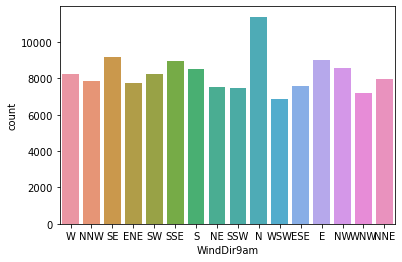

In [12]:
#Visualisation de la distribution de WindDir9am

sns.countplot(data = df, x = 'WindDir9am')

<AxesSubplot:xlabel='WindDir3pm', ylabel='count'>

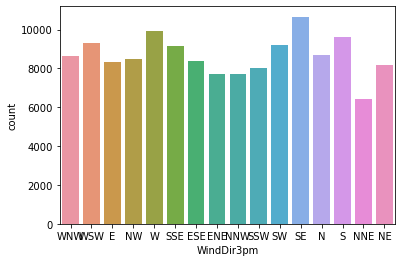

In [13]:
#Visualisation de la distribution de WindDir3pm
sns.countplot(data = df, x = 'WindDir3pm')


<AxesSubplot:xlabel='Location', ylabel='count'>

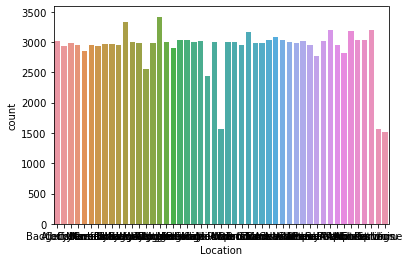

In [14]:
#Visualisation de la distribution de Location
sns.countplot(data = df, x = 'Location')

In [15]:
##Conclusion de l'analyse de la distribution des catégorielles

#-Les vitesses des vents ont une distribution équilibrée du nombre de valeurs par modalités

#-Nous remarquons des outliers que nous gèrerons si possible par la suite.

#-Nous remarquons que les variables n'ont pas les mêmes échelles et certaines sont asymétriques, 
#il faudra donc normaliser les données après encodage (numérisation des catégorielles pour
#rentrer dans les algorithmes)

#-Toutes les variables ont suffisamment de données par modalité et un nombre de modalité qui peut être 
#encodé (filtre 3)

#-Nous traitons la date séparément en tant que variable importante (effet saison par hypothèse)
#en encondant jours, mois, année pour voir l'effet des mois car cette variable contient
#3 informations qui sont en fait 3 variables explicatives différentes à cause de leur 
#échelle différente (jour, mois, année).

In [16]:
##Traitement de date considéré précédemment comme nécessaire

#En l'état, cette variable est inutile, mais comme la pluie est un péhnomène qui semble dépendant des saisons,
# il serait interessant de décomposer Date. Pour cela, nous utilisons la méthode 
#dt.datetime pour extraire année, mois, et jour

df['year'] = pd.to_datetime(df['Date']).dt.year
df['month'] = pd.to_datetime(df['Date']).dt.month
df['day'] = pd.to_datetime(df['Date']).dt.day

#réenregistrement des variables year, month, et day, en tant que int.

df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)

#pour vérifier: 
df.head()

#on élimine la colonne Date, désormais inutile et dont l'information a été conservée.
df = df.drop('Date', axis = 1)

In [17]:
###Première Analyses des corrélations des catégorielles avec la variable cible 

##imports nécessaires :
import statsmodels.api 

##Year et RainTomorrow
 
result = statsmodels.formula.api.ols('year ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##conclusion : la p-value (PR(>F)) est inférieure à 5% : 
#donc "year" influe sur "RainTomorrow" les deux sont significativement corrélées.

                    df         sum_sq     mean_sq          F    PR(>F)
RainTomorrow       1.0     133.099568  133.099568  20.612933  0.000006
Residual      142191.0  918140.133292    6.457090        NaN       NaN


In [18]:
##month et RainTomorrow
 
result = statsmodels.formula.api.ols('month ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##conclusion : la p-value (PR(>F)) est inférieure à 5% : 
#donc month et RainTomorrow sont significativement corrélées.

                    df        sum_sq    mean_sq         F    PR(>F)
RainTomorrow       1.0  8.966127e+01  89.661269  7.636991  0.005719
Residual      142191.0  1.669378e+06  11.740392       NaN       NaN


In [19]:
##day et RainTomorrow
 
result = statsmodels.formula.api.ols('day ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##conclusion : la p-value (PR(>F)) est inférieure à 5%, mais très proche de 5% : 
#donc day et RainTomorrow sont significativement corrélées.

                    df        sum_sq     mean_sq         F    PR(>F)
RainTomorrow       1.0  3.184316e+02  318.431580  4.113797  0.042537
Residual      142191.0  1.100640e+07   77.405756       NaN       NaN


In [20]:
##MinTemp et RainTomorrow
 
result = statsmodels.formula.api.ols('MinTemp ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##conclusion : la p-value (PR(>F)) est inférieure à 5% : 
#donc influe fortement sur Rain Tomorrow donc MinTemp et RainTomorrow sont
#significativement corrélées.

                    df        sum_sq       mean_sq            F         PR(>F)
RainTomorrow       1.0  4.089076e+04  40890.758881  1004.355087  1.200136e-219
Residual      141554.0  5.763151e+06     40.713448          NaN            NaN


In [21]:
##MaxTemp et RainTomorrow :

result = statsmodels.formula.api.ols('MaxTemp ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##conclusion : la p-value (PR(>F)) est inférieure à 5% : 
#donc MaxTemp et RainTomorrow sont significativement corrélées.

                    df        sum_sq        mean_sq            F  PR(>F)
RainTomorrow       1.0  1.822410e+05  182240.995715  3690.861736     0.0
Residual      141869.0  7.004962e+06      49.376273          NaN     NaN


In [22]:
##Sunshine et RainTomorrow

result = statsmodels.formula.api.ols('Sunshine ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##Conclusion : la p-value (PR(>F)) est inférieure à 5% : donc Sunshine et RainTomorrow sont
#significativement corrélées.

                   df         sum_sq        mean_sq             F  PR(>F)
RainTomorrow      1.0  216109.095607  216109.095607  18966.163357     0.0
Residual      74375.0  847462.593413      11.394455           NaN     NaN


In [23]:
##Rainfall et RainTomorrow :

result = statsmodels.formula.api.ols('Rainfall ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##Conclusion : la p-value (PR(>F)) est inférieure à 5% donc 
#Rainfall et RainTomorrow sont significativement corrélées.

                    df        sum_sq        mean_sq            F  PR(>F)
RainTomorrow       1.0  5.764246e+05  576424.599798  8531.370312     0.0
Residual      140785.0  9.512181e+06      67.565301          NaN     NaN


In [24]:
##Evaporation et RainTomorrow :

result = statsmodels.formula.api.ols('Evaporation ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##Conclusion : la p-value (PR(>F)) est inférieure à 5% donc 
#Evaporation et RainTomorrow sont significativement corrélées.

                   df        sum_sq       mean_sq            F         PR(>F)
RainTomorrow      1.0  2.030702e+04  20307.024407  1174.195017  1.656742e-255
Residual      81348.0  1.406867e+06     17.294422          NaN            NaN


In [25]:
##WindGustDir et RainTomorrow :

table = pd.crosstab(df['WindGustDir'],df['RainTomorrow'])

from scipy.stats import chi2_contingency
c, p, dof, expected = chi2_contingency(table) 
print("c = {}, p = {}, dof = {}".format(c, p, dof, 2))

##Conclusion : la p-value (PR(>F)) est inférieure à 5% donc 
#WindGustDir et RainTomorrow sont significativement dépendantes.



c = 1519.9012419828084, p = 0.0, dof = 15


In [26]:
#rappel de la définition du V de cramer
#Le V de Cramer est la racine carrée du χ² divisé par le χ² max. 
# Plus V est proche de zéro, plus il y a indépendance entre les deux variables étudiées.
#  Il vaut 1 en cas de complète dépendance puisque le χ² est alors égal au χ² max 
# (dans un tableau 2 × 2, il prend une valeur comprise entre -1 et 1).

In [27]:
#ajout du test de cramer pour confirmer l'analyse :
table = pd.crosstab(df['WindGustDir'],df['RainTomorrow'])

def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

#Appliquer V_cramer à table avec le nombre d'observations égale à df.shape[0].
V_Cramer(table, df.shape[0])

##Conclusion : le V de cramer est très faible : Donc très faible corrélation entre les deux variables
#Conclusion des 2 tests (Chi2 et Cramer) : 
#WindGustDir et RainTomorrow sont corréllées mais très peu corrélées selon ces 2 tests.

0.10287655285982306

In [28]:
##WindGustSpeed et RainTomorrow :

result = statsmodels.formula.api.ols('WindGustSpeed ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##Conclusion : la p-value est inférieure à 5% donc 
#WindGustSpeed a un effet statistique significatif sur RainTomorrow.

                    df        sum_sq       mean_sq            F  PR(>F)
RainTomorrow       1.0  1.344086e+06  1.344086e+06  7700.511544     0.0
Residual      132921.0  2.320069e+07  1.745450e+02          NaN     NaN


In [29]:
##WindDir9am et RainTomorrow :

table = pd.crosstab(df['WindDir9am'],df['RainTomorrow'])
print(table)
c, p, dof, expected = chi2_contingency(table)
print(c, p, dof)

##Conclusion : la p-value est inférieure à 5% donc 
#WindDir9am et RainTomorrow sont significativement dépendantes selon ce test.

#ajout du test de cramer pour confirmer nos conclusions et préciser la l'importance de la corrélation :

def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))
V_Cramer(table, df.shape[0])

#le V de cramer est faible (0.12) : donc WindDir9am et RainTomorrow sont très faiblement corréll
#selon ce deuxième test

RainTomorrow    No   Yes
WindDir9am              
E             7709  1315
ENE           6370  1365
ESE           6440  1118
N             7883  3510
NE            5959  1568
NNE           5811  2137
NNW           5410  2430
NW            6163  2389
S             6812  1681
SE            7671  1491
SSE           7365  1601
SSW           5803  1645
SW            6328  1909
W             6103  2157
WNW           5246  1948
WSW           5151  1692
2214.8468820751004 0.0 15


0.12438231477050579

In [30]:
##WindDir3pm et RainTomorrow :

table = pd.crosstab(df['WindDir3pm'],df['RainTomorrow'])
#print(table)
c, p, dof, expected = chi2_contingency(table) 
#print(c, p, dof)

##Conclusion du test chi2 : p-value < 5% donc WindDir3pm et RainTomorrow sont significativement 
#corrélées

#ajout du test de cramer pour confirmer:
def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))
V_Cramer(table, df.shape[0])

#le v de cramer est très faible : les variables sont faiblement corréllées.

0.09436805285848933

In [31]:
##WindSpeed9am et RainTomorrow

result = statsmodels.formula.api.ols('WindSpeed9am ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##conclusion : la p-value (PR(>F)) est inférieure à 5% 
#donc WindSpeed9am et RainTomorrow sont significativement corrélées.

                    df        sum_sq       mean_sq            F         PR(>F)
RainTomorrow       1.0  9.223581e+04  92235.812691  1175.920404  1.203343e-256
Residual      140843.0  1.104732e+07     78.437122          NaN            NaN


In [32]:
##WindSpeed3pm et RainTomorrow

result = statsmodels.formula.api.ols('WindSpeed3pm ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

## Conclusion : pla p-value (PR(>F)) est inférieure à 5% 
#donc WindSpeed3pm et RainTomorrow sont significativement corrélées.

                    df        sum_sq       mean_sq            F         PR(>F)
RainTomorrow       1.0  8.341108e+04  83411.084622  1084.644514  5.868664e-237
Residual      139561.0  1.073249e+07     76.901772          NaN            NaN


In [33]:
#etude de Humidity9am et RainTomorrow

result = statsmodels.formula.api.ols('Humidity9am ~ RainTomorrow', data = df).fit()

# suivi de
table = statsmodels.api.stats.anova_lm(result)

print(table)

#la p-value (PR(>F)) est inférieure à 5% : "Humidity9am" corrélé avec RainTomorrow 

                    df        sum_sq       mean_sq            F  PR(>F)
RainTomorrow       1.0  3.370408e+06  3.370408e+06  9943.628385     0.0
Residual      140417.0  4.759455e+07  3.389515e+02          NaN     NaN


In [34]:
##Humidity3pm et RainTomorrow
#result = statsmodels.formula.api.ols('var_num ~ var_cat', data = df).fit() 
result = statsmodels.formula.api.ols('Humidity3pm ~ RainTomorrow', data = df).fit()

# suivi de
table = statsmodels.api.stats.anova_lm(result)

print(table)

#la p-value (PR(>F)) est inférieure à 5% : "Humidity3pm" corrélé avec Rain Tomorrow 

                    df        sum_sq       mean_sq             F  PR(>F)
RainTomorrow       1.0  1.193225e+07  1.193225e+07  34441.750072     0.0
Residual      138581.0  4.801102e+07  3.464473e+02           NaN     NaN


In [35]:
##Pressure9am et RainTomorrow

result = statsmodels.formula.api.ols('Pressure9am ~ RainTomorrow', data = df).fit()

# suivi de
table = statsmodels.api.stats.anova_lm(result)

print(table)

##conlusion : Pressure9am et RainTomorrow sont significativement corrélées

                    df        sum_sq        mean_sq            F  PR(>F)
RainTomorrow       1.0  3.928073e+05  392807.252402  8282.947082     0.0
Residual      128177.0  6.078616e+06      47.423610          NaN     NaN


In [36]:
##Pressure3am et RainTomorrow'

result = statsmodels.formula.api.ols('Pressure3pm ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##conlusion : Pressure3am et RainTomorrow sont significativement corrélées

                    df        sum_sq        mean_sq            F  PR(>F)
RainTomorrow       1.0  3.243374e+05  324337.425885  6902.930246     0.0
Residual      128210.0  6.024007e+06      46.985471          NaN     NaN


In [37]:
#Cloud9am et RainTomorrow

result = statsmodels.formula.api.ols('Cloud9am ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##conlusion : Cloud9am et RainTomorrow sont significativement corrélées

                   df         sum_sq       mean_sq         F  PR(>F)
RainTomorrow      1.0   74331.325275  74331.325275  9916.961     0.0
Residual      88534.0  663595.384933      7.495373       NaN     NaN


In [38]:
##Cloud3pm et RainTomorrow

result = statsmodels.formula.api.ols('Cloud3pm ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##conlusion : Cloud3pm et RainTomorrow sont significativement corrélées

                   df         sum_sq       mean_sq             F  PR(>F)
RainTomorrow      1.0   91852.534384  91852.534384  14527.785412     0.0
Residual      85097.0  538029.362137      6.322542           NaN     NaN


In [39]:
##Temp9am et RainTomorrow

result = statsmodels.formula.api.ols('Temp9am ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##conlusion : Temp9am et RainTomorrow sont significativement corrélées

                    df        sum_sq      mean_sq          F        PR(>F)
RainTomorrow       1.0  3.931248e+03  3931.248309  93.313604  4.533895e-22
Residual      141287.0  5.952340e+06    42.129423        NaN           NaN


In [40]:
##Temp3pm et RainTomorrow

result = statsmodels.formula.api.ols('Temp3pm ~ RainTomorrow', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
print(table)

##conlusion : Temp3pm et RainTomorrow sont significativement corrélées

                    df        sum_sq        mean_sq            F  PR(>F)
RainTomorrow       1.0  2.485450e+05  248544.958193  5362.533296     0.0
Residual      139465.0  6.463983e+06      46.348422          NaN     NaN


In [41]:
##RainToday et RainTomorrow

table = pd.crosstab(df['RainToday'],df['RainTomorrow'])
print(table)
c, p, dof, expected = chi2_contingency(table) 
print(c, p, dof)

#p_value < 5 % donc les deux variables sont significativement corrélées selon ce test

#ajout du test de cramer pour confirmer

def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

#Appliquer V_cramer à table avec le nombre d'observations égale à df.shape[0].
V_Cramer(table, df.shape[0])

#Conclusion intermédiaire: #V_cramer = 0.31, donc RainToday et RainTomorrow sont faiblement corrélées selon ce test.


RainTomorrow     No    Yes
RainToday                 
No            92728  16604
Yes           16858  14597
13799.479649324368 0.0 1


0.3115143355299644

In [42]:
##Location et RainTomorrow

table = pd.crosstab(df['Location'],df['RainTomorrow'])
print(table)
c, p, dof, expected = chi2_contingency(table) 
print(c, p, dof)

#ajout du test de cramer pour confirmer

def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

#Appliquer V_cramer à table avec le nombre d'observations égale à df.shape[0].
V_Cramer(table, df.shape[0])

##V_cramer = 0.15, 
#Conclusion intermédiaire: Location et RainTomorrow sont faiblement corrélées selon ce test


RainTomorrow        No   Yes
Location                    
Adelaide          2402   688
Albany            2114   902
Albury            2393   618
AliceSprings      2787   244
BadgerysCreek     2345   583
Ballarat          2247   781
Bendigo           2472   562
Brisbane          2452   709
Cairns            2038   950
Canberra          2789   629
Cobar             2602   386
CoffsHarbour      2084   869
Dartmoor          2021   922
Darwin            2340   852
GoldCoast         2205   775
Hobart            2427   761
Katherine         1294   265
Launceston        2329   699
Melbourne         1799   636
MelbourneAirport  2356   653
Mildura           2680   327
Moree             2460   394
MountGambier      2110   920
MountGinini       2088   819
Newcastle         2224   731
Nhil              1327   242
NorahHead         2121   808
NorfolkIsland     2045   919
Nuriootpa         2410   592
PearceRAAF        2257   505
Penrith           2369   595
Perth             2548   645
PerthAirport  

0.15681845999773006

In [148]:
##Fin de la préparation des données avant les derniers tris sur les variables: 


#  Centrer et réduire les variables numériques du Dataframe, à l'aide d'une instance de la classe preprocessing.StandardScaler.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#d'abord, créer un df alternatif, que nous ne normaliserons pas.

df_nonnorm = df

#normalisation de df
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
name_columns_numerics = df.select_dtypes(include=numerics).columns
#créer, Entrainer et transformer directement les colonnes numériques de df
scaler =  preprocessing.StandardScaler()
df[name_columns_numerics] = scaler.fit_transform(df[name_columns_numerics])


# Transformer chaque variable catégorielle en variables indicatrices.

##Encodage de RainTomorrow et RainToday:
df['RainToday_encode'] = df['RainToday']
df['RainTomorrow_encode'] = df['RainTomorrow']
df = df.drop(labels = ['RainTomorrow', 'RainToday'], axis = 1)

#import: 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

#encodage : 
for var in df.select_dtypes(include='object').columns:
    df[var] = le.fit_transform(df[var])

#vérifier si toutes les colonnes sont bien numérisées :
print(df.head())

'''
##Fin de la préparation des données avant les derniers tris sur les variables: 
#Encodage de toutes les explicatives catégorielles  
#avant la matrice de corrélation de Pearson et pour les algorithmes de Machine Learning :

##Encodage de RainTomorrow et RainToday:
df['RainToday_encode'] = df['RainToday'].replace({'No': 0, 'Yes': 1})
df['RainTomorrow_encode'] = df['RainTomorrow'].replace({'No': 0, 'Yes': 1})

#suppression des anciennes variables cible encodées qui ne seront plus utiles (algorithmes et tests que sur des 
#variables numériques):
df = df.drop(labels = ['RainTomorrow', 'RainToday'], axis = 1)

##vérifier l'encodage : c'est bon.
print(df['RainTomorrow_encode'].head())
print(df['RainToday_encode'].head())
'''

KeyError: 'RainToday'

<AxesSubplot:xlabel='RainTomorrow_encode', ylabel='count'>

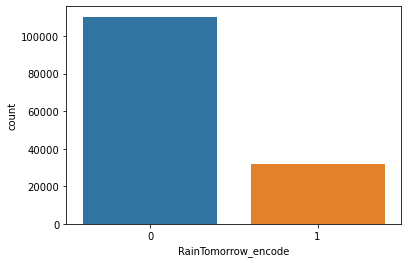

In [44]:
#vérifier l'encodage
sns.countplot(data = df, x = 'RainTomorrow_encode')

In [45]:
#vérification de l'état correct du jeu de données : c'est bon.
print(df.head())

   Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir  \
0         2  0.189528 -0.045912 -0.206727          NaN       NaN           13   
1         2 -0.747494  0.263181 -0.277606          NaN       NaN           14   
2         2  0.111443  0.347479 -0.277606          NaN       NaN           15   
3         2 -0.466387  0.670622 -0.277606          NaN       NaN            4   
4         2  0.829827  1.274759 -0.159474          NaN       NaN           13   

   WindGustSpeed  WindDir9am  WindDir3pm  WindSpeed9am  WindSpeed3pm  \
0       0.295517          13          14      0.674441      0.609137   
1       0.295517           6          15     -1.124665      0.381950   
2       0.442698          13          15      0.561997      0.836324   
3      -1.176289           9           0     -0.337556     -1.094767   
4       0.074746           1           7     -0.787332      0.154763   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  \
0  

In [46]:
#Créer, Entrainer et transformer directement les variables explicatives : 
#scaler =  StandardScaler()
#df = scaler.fit_transform(df)

#reconvertir en dataframes et concaténer pour retrouver notre jeu de données complet (explicatives et cible)
#df = pd.DataFrame(df)
#target = pd.DataFrame(target)
#df = pd.concat([feats, target], axis = 1)
#df.columns = colnames

In [47]:
#vérification de l'état correct des données du dataframe normalisées (sauf la cible) : c'est bon.
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,year,month,day,RainToday_encode,RainTomorrow_encode
0,2,0.189528,-0.045912,-0.206727,NaN,NaN,13,0.295517,13,14,0.674441,0.609137,0.113179,-1.417590,-1.400863,-1.159388,1.234088,NaN,-0.013478,0.016254,-1.872674,1.633581,-1.672526,0,0
1,2,-0.747494,0.263181,-0.277606,NaN,NaN,14,0.295517,6,15,-1.124665,0.381950,-1.304053,-1.273343,-0.992725,-1.059908,NaN,NaN,0.032727,0.376611,-1.872674,1.633581,-1.558865,0,0
2,2,0.111443,0.347479,-0.277606,NaN,NaN,15,0.442698,13,15,0.561997,0.836324,-1.618994,-1.032932,-1.414937,-0.932007,NaN,-0.920073,0.617989,0.218054,-1.872674,1.633581,-1.445205,0,0
3,2,-0.466387,0.670622,-0.277606,NaN,NaN,4,-1.176289,9,0,-0.337556,-1.094767,-1.251563,-1.706083,-0.007566,-0.349343,NaN,NaN,0.171342,0.693725,-1.872674,1.633581,-1.331544,0,0
4,2,0.829827,1.274759,-0.159474,NaN,NaN,13,0.074746,1,7,-0.787332,0.154763,0.690569,-0.888685,-0.964578,-1.315712,0.887707,1.285309,0.125137,1.154982,-1.872674,1.633581,-1.217883,0,0


In [48]:
#A ce stade, df contient toutes les explicatives normalisées
# et la cible encodées et avec un premier nettoyage des données qui demande plus d'informations 
#pour pouvoir être continué.

In [49]:
##Filtre 3 : variables non significativement corrélées (p-value pearson)  >5%.

#Calcul de la p-value de Pearson pour étudier
# la significativité de la relation de chacune des explicatives 
#à la variable cible au seuil de rejet de 5% avec hypothèse de test 
#H0 : "les variables sont significativement corréllées":
from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues
p_values_df = calculate_pvalues(df)
p_values_df['RainTomorrow_encode'].sort_values(ascending=False)

#Résultats : les variables "day", "WindGustDir", "year" ne sont par significativement corréllées à
#RainTomorrow (variable cible) donc elles sont supprimées.

day                    0.7464
month                  0.7109
Location               0.1987
year                   0.1311
Temp9am                0.0053
Humidity3pm               0.0
RainToday_encode          0.0
Temp3pm                   0.0
Cloud3pm                  0.0
Cloud9am                  0.0
Pressure3pm               0.0
Pressure9am               0.0
Humidity9am               0.0
MinTemp                   0.0
WindSpeed3pm              0.0
WindSpeed9am              0.0
WindDir3pm                0.0
WindDir9am                0.0
WindGustSpeed             0.0
WindGustDir               0.0
Sunshine                  0.0
Evaporation               0.0
Rainfall                  0.0
MaxTemp                   0.0
RainTomorrow_encode       0.0
Name: RainTomorrow_encode, dtype: object

In [50]:
#suppression des variables non significativement corréllées à RainTomorrow d'après la p-value de Pearson :
df = df.drop(labels = ["day", "WindGustDir", "year"], axis = 1)

In [51]:
#vérification de l'état correct du jeu de données complet après les suppressions : c'est bon
print(df.head())

   Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
0         2  0.189528 -0.045912 -0.206727          NaN       NaN   
1         2 -0.747494  0.263181 -0.277606          NaN       NaN   
2         2  0.111443  0.347479 -0.277606          NaN       NaN   
3         2 -0.466387  0.670622 -0.277606          NaN       NaN   
4         2  0.829827  1.274759 -0.159474          NaN       NaN   

   WindGustSpeed  WindDir9am  WindDir3pm  WindSpeed9am  WindSpeed3pm  \
0       0.295517          13          14      0.674441      0.609137   
1       0.295517           6          15     -1.124665      0.381950   
2       0.442698          13          15      0.561997      0.836324   
3      -1.176289           9           0     -0.337556     -1.094767   
4       0.074746           1           7     -0.787332      0.154763   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  \
0     0.113179    -1.417590    -1.400863    -1.159388  1.234088       NaN   
1   

<AxesSubplot:>

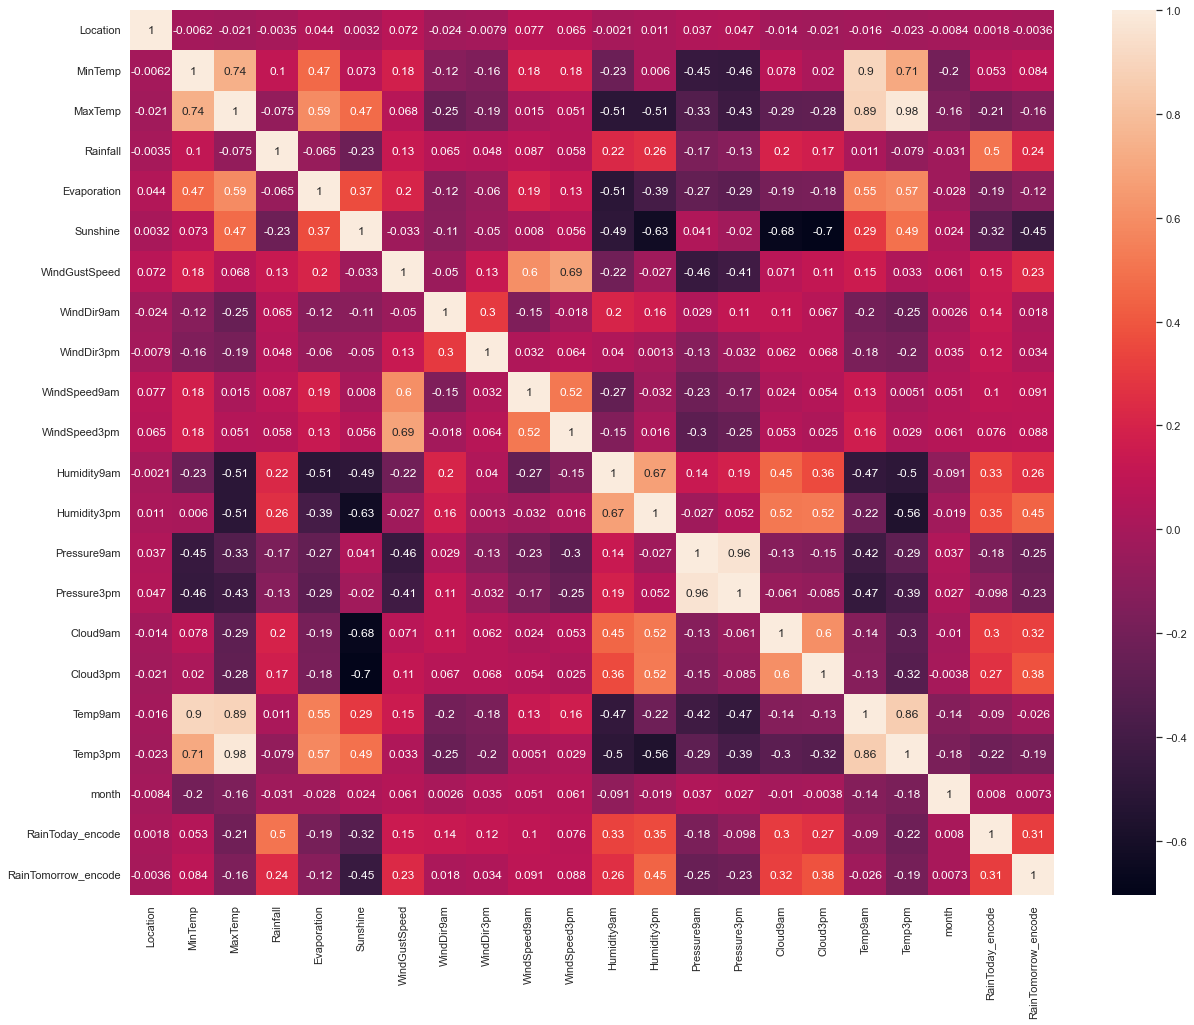

In [52]:
###Fitlre 4 : Tri des variables corrélées à moins de 5% à target : 

#Toutes les variables sont encodées donc nous pouvons analyser les corrélations de toutes les variables pour confirmer
#les tests précédents et pour conclure ensuite sur le choix des variables conservées.

#matrice de corrélation en "heatmap" :
Var_Corr = df.corr()
sns.set(rc={'figure.figsize':(20.7,16.27)})
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

In [53]:
##visualisation des corrélations de Pearson à la variable cible 
#en valeur absolue pour filtrer les variables < 5% par ordre d'importance de
#corrélation (positive ou négative) à la variable cible.
print(100*abs(Var_Corr['RainTomorrow_encode']).sort_values(ascending = False))

RainTomorrow_encode    100.000000
Sunshine                45.076806
Humidity3pm             44.616038
Cloud3pm                38.187041
Cloud9am                31.737983
RainToday_encode        30.965171
Humidity9am             25.716116
Pressure9am             24.637115
Rainfall                23.903180
WindGustSpeed           23.400973
Pressure3pm             22.603115
Temp3pm                 19.242409
MaxTemp                 15.923666
Evaporation             11.928470
WindSpeed9am             9.099465
WindSpeed3pm             8.781740
MinTemp                  8.393581
WindDir3pm               3.443519
Temp9am                  2.569082
WindDir9am               1.843647
month                    0.732847
Location                 0.357920
Name: RainTomorrow_encode, dtype: float64


In [54]:
###TRI FINAL (voir le document joint PDF pour l'argumentation): REVOIR

#Les résultats de tous les tests statistiques ainsi que l'argumentation sur les choix des variables
#explicatives conservées sont indiqués dans un document joint en pdf.

#Les nouveaux seuils pour filtrer les variables explicatives sont les suivants:
#Pearson : 5% (seuil conventionnel), afin de ne pas perdre trop d'information notamment sur les vents
#corrélation avec une autre variable explicative : 85%, afin de ne pas perdre trop d'information
#mais de ne pas avoir de variables qui ont la même information. Nous avons hésité avec 70% mais 
#nous avons voulu être prudent et augmenter ce seuil.


#suppression des variables filtrées suite au travail précédent : 
#df = df.drop(labels = ["MaxTemp", "Pressure3pm", "Temp9am", "WindDir3pm", "WindDir9am"], axis = 1)

df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,month,RainToday_encode,RainTomorrow_encode
0,2,0.189528,-0.045912,-0.206727,NaN,NaN,0.295517,13,14,0.674441,0.609137,0.113179,-1.417590,-1.400863,-1.159388,1.234088,NaN,-0.013478,0.016254,1.633581,0,0
1,2,-0.747494,0.263181,-0.277606,NaN,NaN,0.295517,6,15,-1.124665,0.381950,-1.304053,-1.273343,-0.992725,-1.059908,NaN,NaN,0.032727,0.376611,1.633581,0,0
2,2,0.111443,0.347479,-0.277606,NaN,NaN,0.442698,13,15,0.561997,0.836324,-1.618994,-1.032932,-1.414937,-0.932007,NaN,-0.920073,0.617989,0.218054,1.633581,0,0
3,2,-0.466387,0.670622,-0.277606,NaN,NaN,-1.176289,9,0,-0.337556,-1.094767,-1.251563,-1.706083,-0.007566,-0.349343,NaN,NaN,0.171342,0.693725,1.633581,0,0
4,2,0.829827,1.274759,-0.159474,NaN,NaN,0.074746,1,7,-0.787332,0.154763,0.690569,-0.888685,-0.964578,-1.315712,0.887707,1.285309,0.125137,1.154982,1.633581,0,0


In [55]:
#on vérifie qu'il n'y a plus de nans dans RainTomorrow

print((100*df.isna().sum()/df.shape[0]).sort_values(ascending = False))

#à ce stade, il n' y a pas de choix évident : 

#1/soit nous supprimons toutes 
#les lignes contenant au mois une valeur manquante (scénario "bourrin")

#2/soit nous supprimons des variables à fort 
#taux de manquantes mais fortement corrélées (scénario subtil1)

#3/soit nous remplaçons les valeurs manquantes par imputation statistique (moyenne) (scénario subtil2)

#Ne sachant pas quel scénario est le meilleur, nous testons en premier le scénario df_bourrin
#et ensuite nous comparerons les résultats finaux avec les autres dataset pour vérifier 
#le meilleur choix de dataset de variables explicatives.

Sunshine               47.692924
Evaporation            42.789026
Cloud3pm               40.152469
Cloud9am               37.735332
Pressure9am             9.855619
Pressure3pm             9.832411
WindGustSpeed           6.519308
Humidity3pm             2.538803
Temp3pm                 1.917113
WindSpeed3pm            1.849599
Humidity9am             1.247600
Rainfall                0.988797
WindSpeed9am            0.948007
Temp9am                 0.635756
MinTemp                 0.447983
MaxTemp                 0.226453
month                   0.000000
RainToday_encode        0.000000
Location                0.000000
WindDir3pm              0.000000
WindDir9am              0.000000
RainTomorrow_encode     0.000000
dtype: float64


In [56]:
###Etude du jeu de données "bourrin" :
### on supprime toutes les lignes ou il y a une manquante :

df_bourrin = df.dropna()

df_bourrin.shape

##Evaluation de la perte : perte de 58 111/142 193 = 60% des données à 1% près.

(58090, 22)

In [57]:
##verification : il n'y a plus de manquantes.
df_bourrin.isna().sum()

Location               0
MinTemp                0
MaxTemp                0
Rainfall               0
Evaporation            0
Sunshine               0
WindGustSpeed          0
WindDir9am             0
WindDir3pm             0
WindSpeed9am           0
WindSpeed3pm           0
Humidity9am            0
Humidity3pm            0
Pressure9am            0
Pressure3pm            0
Cloud9am               0
Cloud3pm               0
Temp9am                0
Temp3pm                0
month                  0
RainToday_encode       0
RainTomorrow_encode    0
dtype: int64

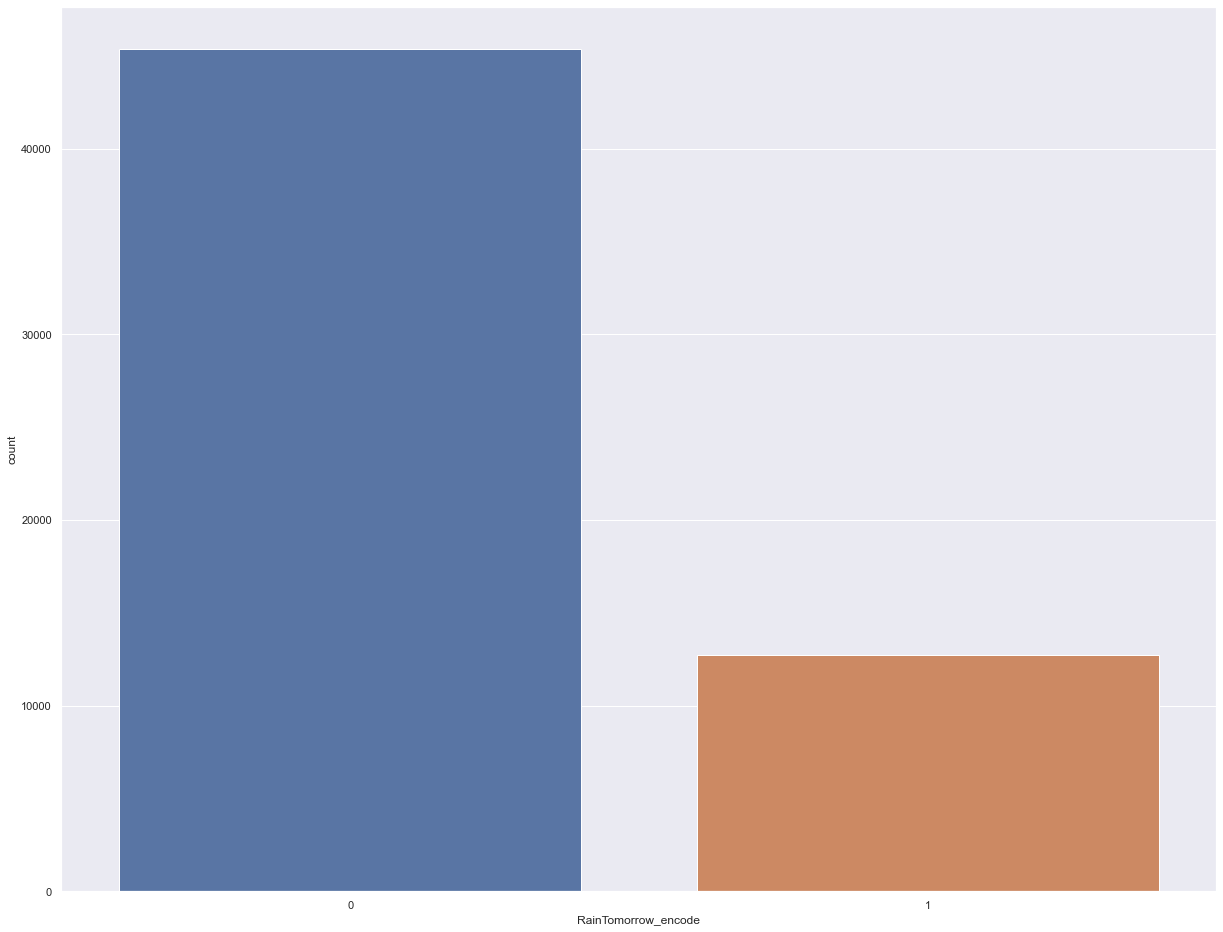

In [58]:
#vérification de la répartition des valeurs dans les 2 modalités de la variable cible , 
#via un count plot.
#Analyse : la répartition est toujours déséquilibrée.
sns.countplot(data = df_bourrin, x = 'RainTomorrow_encode');

In [59]:
df_bourrin.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,month,RainToday_encode,RainTomorrow_encode
6049,10,0.892296,1.682200,-0.277606,1.559069,1.236321,0.589878,1,12,-0.899777,0.154763,-2.563815,-1.850330,-1.597895,-1.543093,-0.844195,0.182618,1.480481,1.688310,-1.576698,0,0
6050,10,0.970381,0.797069,-0.277606,2.227564,1.421433,-0.219615,10,10,0.561997,0.041169,-2.038914,-2.090741,-0.669030,-0.448822,-1.190575,-1.287637,0.510178,0.765796,-1.576698,0,0
6052,10,1.126551,2.019393,-0.277606,1.272571,0.786764,0.442698,5,6,1.798883,-0.413205,-1.409033,-1.417590,-0.753472,-0.860950,-1.190575,0.550182,1.803916,1.904524,-1.576698,0,0
6053,10,1.516977,2.131790,-0.277606,1.415820,1.209876,-0.661157,14,15,-0.899777,-1.435548,-1.671484,-1.417590,-0.697177,-0.875161,-1.190575,0.182618,1.865522,2.005424,-1.576698,0,0
6054,10,1.876169,2.497082,-0.277606,1.368070,0.204984,-0.366795,7,14,0.337109,-0.640392,-2.616305,-1.754166,-0.978652,-1.116754,-1.190575,0.550182,2.558596,2.293709,-1.576698,0,0


In [60]:
##découpage du jeu de données.
from sklearn import model_selection, preprocessing
from sklearn.neighbors import KNeighborsClassifier

y = df_bourrin['RainTomorrow_encode']
x = df_bourrin.drop('RainTomorrow_encode', axis = 1)
print(x)

        Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
6049          10  0.892296  1.682200 -0.277606     1.559069  1.236321   
6050          10  0.970381  0.797069 -0.277606     2.227564  1.421433   
6052          10  1.126551  2.019393 -0.277606     1.272571  0.786764   
6053          10  1.516977  2.131790 -0.277606     1.415820  1.209876   
6054          10  1.876169  2.497082 -0.277606     1.368070  0.204984   
...          ...       ...       ...       ...          ...       ...   
142298        13  1.110934  1.429306 -0.277606     0.126579  0.892542   
142299        13  1.407658  1.316908 -0.277606     0.508576  0.257873   
142300        13  1.329573  1.345007 -0.277606     0.031079  0.892542   
142301        13  1.142168  1.204511 -0.277606     0.174328  0.786764   
142302        13  1.251488  1.190461 -0.277606     0.031079  0.813208   

        WindGustSpeed  WindDir9am  WindDir3pm  WindSpeed9am  WindSpeed3pm  \
6049         0.589878           1          12 

In [61]:
#reformatage des dimensions de y pour permettre de rentrer les données dans traintestsplit :

y = np.array(y)
y.reshape(-1, 1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [62]:
##Découpage des données en jeu d'entrainement et jeu test pou
#permettre d'évaluer la performanc des modèles sur un jeu nouveau :

#20 % des données en test, avec en paramètre randomstate=42 rempli pour la reproductibilité 
#des résultats :
from sklearn.model_selection import train_test_split
#y = y.astype(str)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)


In [63]:
#vérification de la séparation : la séparation a été correctement effectuée (20%).
x_train.shape

(46472, 21)

In [64]:
#vérifier si y_test contient bien les deux valeurs de RainTomorrow_encode
y_test_verif = pd.Series(y_test)
y_test_verif.value_counts()

0    9059
1    2559
dtype: int64

![Picture title](image-20220714-195101.png)

In [65]:
###Test de modèles

##Choix des modèles : après concertation, nous avons décidé de tester les modèles suivants selon
#en se basant sur la méthode de scikit-learn et aussi en choisissant
# aussi des modèles supposés simples donc rapides :
# -> classifieurs :
# -1) SVM linéaire  :  Nous avons moins de 100 000 données, notre target est de type booléenne (0 et 1).
# il est possible de commencer par un classifieur SVM linéaire
#commme indiqué par la méthode de choix de modèles de scikitlearn (voir figure ci dessus).

# -2) KNN qui vient ensuite selon la méthode scikit learn et car nos données ne sont pas textuelles

# -3) arbre de décision : car la plus simple des méthodes ensemblistes

# -4) régression logistique : adaptée car notre target est catégorielle et comme modèle potentiellement 
#rapide.


##Rééchantilonnage : Nous posons l'hypothèse de l'obtention de 
#meilleurs résulats suite à l'"oversampling" car nous corrigeons le problème de déséquilibre de la distribution :
#Test de l'hypothèse : nous testons les résultats sans puis avec oversampling pour valider cette hypothèse.

In [66]:
###Test du premier modèle SVM linéaire et réglage de ses hyperparamètres:


#Le calcul de la gridsearch BEAUCOUP de temps soit plus de 24 H, nous avons néanmoins obtenu les 
#meilleurs paramètres. : 
#- C = 1000,gamma = 0.001.
#Avec ces meilleurs paramètres, nous n'avons pas un temps satisfaisant (supérieur à 1h30) de calcul du 
#résultat, ce modèle est donc écarté malgré son score correct. De plus car nous avons d'autres modèles utilisables plus rapides.

#Nous avons laissé la trace du code pour montrer le travail fourni et pour réutilisation éventuelle ultérieure.

'''
#(version de lancement le 14/07/2022 à 21h.)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
params = {"kernel": ["linear"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]}
gs = GridSearchCV(SVC(), params, verbose = 1, cv = 5)
gs.fit(x_train, y_train)
display(print(gs.best_score_))
display(print(gs.best_estimator_))
display(print(gs.best_params_))
'''


'\n#(version de lancement le 14/07/2022 à 21h.)\nfrom sklearn.svm import SVC\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.metrics import f1_score\nparams = {"kernel": ["linear"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]}\ngs = GridSearchCV(SVC(), params, verbose = 1, cv = 5)\ngs.fit(x_train, y_train)\ndisplay(print(gs.best_score_))\ndisplay(print(gs.best_estimator_))\ndisplay(print(gs.best_params_))\n'

In [67]:
#Itération du modèle : avec le jeu de données entier :
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
'''
model = SVC(C=1000, gamma = 0.001, kernel='linear') 
model.fit(x_train,y_train)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

#obtenir l'accuracy
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

#obtenir le F1 score
f1score_train = f1_score(y_train, y_pred_train, average='macro')
f1score_test = f1_score(y_test, y_pred_test, average='macro')

#afficher l'accuracy et F1 score
print("acc_train : ", acc_train, "acc_test :", acc_test)
print("F1score_train : ", f1score_train, "F1score_test :", f1score_test)
'''

'\nmodel = SVC(C=1000, gamma = 0.001, kernel=\'linear\') \nmodel.fit(x_train,y_train)\n\ny_pred_train = model.predict(x_train)\ny_pred_test = model.predict(x_test)\n\n#obtenir l\'accuracy\nacc_train = accuracy_score(y_train, y_pred_train)\nacc_test = accuracy_score(y_test, y_pred_test)\n\n#obtenir le F1 score\nf1score_train = f1_score(y_train, y_pred_train, average=\'macro\')\nf1score_test = f1_score(y_test, y_pred_test, average=\'macro\')\n\n#afficher l\'accuracy et F1 score\nprint("acc_train : ", acc_train, "acc_test :", acc_test)\nprint("F1score_train : ", f1score_train, "F1score_test :", f1score_test)\n'

In [68]:
##Test du modèle SVM avec les meilleurs hyperparamètres avec rééchantillonnage du jeu de données par undersampling:

'''
#import des librairies
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids

#Random Undersampling
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(x, y)
print('Classes échantillon undersampled :', dict(pd.Series(y_ru).value_counts()))

#Centroids
#cc = ClusterCentroids()
#X_cc, y_cc = cc.fit_resample(x, y)
#print('Classes échantillon CC :', dict(pd.Series(y_cc).value_counts()))
'''

"\n#import des librairies\n!pip install imblearn\nfrom imblearn.over_sampling import RandomOverSampler, SMOTE\nfrom imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids\n\n#Random Undersampling\nrUs = RandomUnderSampler()\nX_ru, y_ru = rUs.fit_resample(x, y)\nprint('Classes échantillon undersampled :', dict(pd.Series(y_ru).value_counts()))\n\n#Centroids\n#cc = ClusterCentroids()\n#X_cc, y_cc = cc.fit_resample(x, y)\n#print('Classes échantillon CC :', dict(pd.Series(y_cc).value_counts()))\n"

In [69]:
#Répartition en jeux train et test :
'''
x_ru_train, x_ru_test, y_ru_train, y_ru_test = train_test_split(X_ru, y_ru, test_size=0.20, random_state=42)'''

'\nx_ru_train, x_ru_test, y_ru_train, y_ru_test = train_test_split(X_ru, y_ru, test_size=0.20, random_state=42)'

In [70]:
#Itération du modèle : svc linéaire, avec les données réduites.

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
'''
model = SVC(C=1000.0, gamma = 0.001, kernel='linear') 
model.fit(x_ru_train,y_ru_train)

y_pred_train = model.predict(x_ru_train)
y_pred_test = model.predict(x_ru_test)

#obtenir l'accuracy
acc_train = accuracy_score(y_ru_train, y_pred_train)
acc_test = accuracy_score(y_ru_test, y_pred_test)

#obtenir le F1 score
f1score_train = f1_score(y_ru_train, y_pred_train, average='macro')
f1score_test = f1_score(y_ru_test, y_pred_test, average='macro')

#afficher l'accuracy et F1 score
print("acc_train : ", acc_train, "acc_test :", acc_test)
print("F1score_train : ", f1score_train, "F1score_test :", f1score_test)
'''

'\nmodel = SVC(C=1000.0, gamma = 0.001, kernel=\'linear\') \nmodel.fit(x_ru_train,y_ru_train)\n\ny_pred_train = model.predict(x_ru_train)\ny_pred_test = model.predict(x_ru_test)\n\n#obtenir l\'accuracy\nacc_train = accuracy_score(y_ru_train, y_pred_train)\nacc_test = accuracy_score(y_ru_test, y_pred_test)\n\n#obtenir le F1 score\nf1score_train = f1_score(y_ru_train, y_pred_train, average=\'macro\')\nf1score_test = f1_score(y_ru_test, y_pred_test, average=\'macro\')\n\n#afficher l\'accuracy et F1 score\nprint("acc_train : ", acc_train, "acc_test :", acc_test)\nprint("F1score_train : ", f1score_train, "F1score_test :", f1score_test)\n'

In [71]:
#matrice de confusion
'''
pd.crosstab(y_test, y_pred_test, rownames=['Classe réelle'], colnames=['Classe prédite'])
'''

"\npd.crosstab(y_test, y_pred_test, rownames=['Classe réelle'], colnames=['Classe prédite'])\n"

In [72]:
#Test de l'hypothèse de feature selection plus drastique combiné à l'oversampling

In [73]:
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
'''
#Instancier un modèle de régression linéaire lr.
clf = SVC(C=1000.0, gamma = 0.001, kernel='linear')

#Créer un sélecteur sfm instance de la classe SelectFromModel, à partir du modèle lr créé.
sfm = SelectFromModel(clf)

sfm_train = sfm.fit_transform(x_train, y_train)

sfm_test = sfm.transform(x_test)


# Afficher les noms des colonnes sélectionnés par sfm grâce à la méthode get_support.
x_train.columns[sfm.get_support()]
'''

"\n#Instancier un modèle de régression linéaire lr.\nclf = SVC(C=1000.0, gamma = 0.001, kernel='linear')\n\n#Créer un sélecteur sfm instance de la classe SelectFromModel, à partir du modèle lr créé.\nsfm = SelectFromModel(clf)\n\nsfm_train = sfm.fit_transform(x_train, y_train)\n\nsfm_test = sfm.transform(x_test)\n\n\n# Afficher les noms des colonnes sélectionnés par sfm grâce à la méthode get_support.\nx_train.columns[sfm.get_support()]\n"

In [74]:
# Afficher les noms des colonnes sélectionnés par sfm grâce à la méthode get_support.
'''
cols = sfm.get_support(indices=True)
features_reduced = hp.iloc[:,cols]

features_reduced.head()
'''

'\ncols = sfm.get_support(indices=True)\nfeatures_reduced = hp.iloc[:,cols]\n\nfeatures_reduced.head()\n'

In [75]:
#relance de la SVM avec hyperparamètres identiques, et x remplacés par features_reduced
'''
model = SVC(C=1000.0, gamma = 0.001, kernel='linear')
model.fit(sfm_train,y_train)

y_pred_train = model.predict(sfm_train)
y_pred_test = model.predict(sfm_test)

#obtenir l'accuracy
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

#obtenir le F1 score
f1score_train = f1_score(y_train, y_pred_train, average='macro')
f1score_test = f1_score(y_test, y_pred_test, average='macro')

#afficher l'accuracy et F1 score
print("acc_train : ", acc_train, "acc_test :", acc_test)
print("F1score_train : ", f1score_train, "F1score_test :", f1score_test)
'''

'\nmodel = SVC(C=1000.0, gamma = 0.001, kernel=\'linear\')\nmodel.fit(sfm_train,y_train)\n\ny_pred_train = model.predict(sfm_train)\ny_pred_test = model.predict(sfm_test)\n\n#obtenir l\'accuracy\nacc_train = accuracy_score(y_train, y_pred_train)\nacc_test = accuracy_score(y_test, y_pred_test)\n\n#obtenir le F1 score\nf1score_train = f1_score(y_train, y_pred_train, average=\'macro\')\nf1score_test = f1_score(y_test, y_pred_test, average=\'macro\')\n\n#afficher l\'accuracy et F1 score\nprint("acc_train : ", acc_train, "acc_test :", acc_test)\nprint("F1score_train : ", f1score_train, "F1score_test :", f1score_test)\n'

In [76]:
#matrice de confusion
'''
pd.crosstab(y_test, y_pred_test, rownames=['Classe réelle'], colnames=['Classe prédite'])
'''

"\npd.crosstab(y_test, y_pred_test, rownames=['Classe réelle'], colnames=['Classe prédite'])\n"

In [77]:
#alternative de resampling 3 : réduction de la complexité via ACP et relance

from sklearn.decomposition import PCA
'''
pca = PCA()
pca.fit(x_train)

plt.figure()
plt.xlim(0,100)
plt.plot(pca.explained_variance_ratio_);

plt.figure()
plt.xlim(0,100)
plt.axhline(y = 0.95, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());
'''

"\npca = PCA()\npca.fit(x_train)\n\nplt.figure()\nplt.xlim(0,100)\nplt.plot(pca.explained_variance_ratio_);\n\nplt.figure()\nplt.xlim(0,100)\nplt.axhline(y = 0.95, color ='r', linestyle = '--')\nplt.plot(pca.explained_variance_ratio_.cumsum());\n"

In [78]:
#réduction de x_train et x_test via ACP
'''
pca = PCA(n_components = 0.90)    #à déterminer selon résultat ci dessus
#(n_components = 0.90) = nbr de composantes pour conserver 90% de la variance expliquée cumulée

x_train_pca = pca.fit_transform(x_train)
print("Nombre de composantes retenues :", pca.n_components_)

x_test_pca = pca.transform(x_test)
'''

'\npca = PCA(n_components = 0.90)    #à déterminer selon résultat ci dessus\n#(n_components = 0.90) = nbr de composantes pour conserver 90% de la variance expliquée cumulée\n\nx_train_pca = pca.fit_transform(x_train)\nprint("Nombre de composantes retenues :", pca.n_components_)\n\nx_test_pca = pca.transform(x_test)\n'

In [79]:
#relance de la SVM avec hyperparamètres identiques, et x remplacés par x_pca
'''
model = SVC(C=1000.0, gamma = 0.001, kernel='linear')
model.fit(x_train_pca, y_train)

y_pred_train = model.predict(x_train_pca)
y_pred_test = model.predict(x_test_pca)

#obtenir l'accuracy
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

#obtenir le F1 score
f1score_train = f1_score(y_train, y_pred_train, average='macro')
f1score_test = f1_score(y_test, y_pred_test, average='macro')

#afficher l'accuracy et F1 score
print("acc_train : ", acc_train, "acc_test :", acc_test)
print("F1score_train : ", f1score_train, "F1score_test :", f1score_test)
'''

'\nmodel = SVC(C=1000.0, gamma = 0.001, kernel=\'linear\')\nmodel.fit(x_train_pca, y_train)\n\ny_pred_train = model.predict(x_train_pca)\ny_pred_test = model.predict(x_test_pca)\n\n#obtenir l\'accuracy\nacc_train = accuracy_score(y_train, y_pred_train)\nacc_test = accuracy_score(y_test, y_pred_test)\n\n#obtenir le F1 score\nf1score_train = f1_score(y_train, y_pred_train, average=\'macro\')\nf1score_test = f1_score(y_test, y_pred_test, average=\'macro\')\n\n#afficher l\'accuracy et F1 score\nprint("acc_train : ", acc_train, "acc_test :", acc_test)\nprint("F1score_train : ", f1score_train, "F1score_test :", f1score_test)\n'

In [80]:
#matrice de confusion
'''
pd.crosstab(y_test, y_pred_test, rownames=['Classe réelle'], colnames=['Classe prédite'])
'''

"\npd.crosstab(y_test, y_pred_test, rownames=['Classe réelle'], colnames=['Classe prédite'])\n"

In [81]:
### Test du modèle numéro 2 : KNN classifieur

from sklearn.neighbors import KNeighborsClassifier

In [82]:
#KNN avec gridsearchCV
from sklearn.model_selection import GridSearchCV
'''
params = {'n_neighbors': range(1, 30), 'weights' : ['uniform', 'distance'], 
'metric' : ['euclidian', 'manhattan', "Minkowski"]}

gs = GridSearchCV(KNeighborsClassifier(), params, verbose = 1, cv = 5)

gs.fit(x_train, y_train)

display(print(gs.best_score_))
display(print(gs.best_estimator_))
display(print(gs.best_params_))
'''
##la computation prend du temps, résultat de la gridsearchCV pour KNN :  
# Autre possibilité : utiliser un script simplifié pour déterminer le meilleur nombre de voisins.
#Nous obtenons '\nparams = (metric='manhattan', n_neighbors=24, weights='distance')
##la computation prend du temps... résultat de la gridsearchCV pour KNN :  \n# Autre possibilité : utiliser un script simplifié pour déterminer le meilleur nombre de voisins.\n'


'\nparams = {\'n_neighbors\': range(1, 30), \'weights\' : [\'uniform\', \'distance\'], \n\'metric\' : [\'euclidian\', \'manhattan\', "Minkowski"]}\n\ngs = GridSearchCV(KNeighborsClassifier(), params, verbose = 1, cv = 5)\n\ngs.fit(x_train, y_train)\n\ndisplay(print(gs.best_score_))\ndisplay(print(gs.best_estimator_))\ndisplay(print(gs.best_params_))\n'

In [152]:
#comparer avec df non norl

df_nonnorm = df_nonnorm.dropna()

##découpage du jeu de données.
from sklearn import model_selection, preprocessing
from sklearn.neighbors import KNeighborsClassifier

y = df_nonnorm['RainTomorrow_encode']
x = df_nonnorm.drop('RainTomorrow_encode', axis = 1)
print(x)

#reformatage des dimensions de y pour permettre de rentrer les données dans traintestsplit :

y = np.array(y)
y = y.astype(str)
y.reshape(-1, 1)

##Découpage des données en jeu d'entrainement et jeu test pou
#permettre d'évaluer la performanc des modèles sur un jeu nouveau :

#20 % des données en test, avec en paramètre randomstate=42 rempli pour la reproductibilité 
#des résultats :
from sklearn.model_selection import train_test_split
#y = y.astype(str)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)


#maintenant que l'on connait le nbr de voisins idéal, évaluons le modèle : 

##Matrice de confusion, accuracy et f1-score : 

model = KNeighborsClassifier(metric='manhattan', n_neighbors=24, weights='distance') #mettre ici le meilleur nbr_voisins trouvé plus haut
model.fit(x_train,y_train)
y_pred_train_KNN1 = model.predict(x_train)
y_pred_test_KNN1 = model.predict(x_test)

#accuracy : 
acc_train_KNN1 = accuracy_score(y_train, y_pred_train_KNN1)
acc_test_KNN1 = accuracy_score(y_test, y_pred_test_KNN1)

#F1 score :
f1score_train_KNN1 = f1_score(y_train, y_pred_train_KNN1, average='macro')
f1score_test_KNN1 = f1_score(y_test, y_pred_test_KNN1, average='macro')

#afficher l'accuracy et F1 score :
print("acc_train : ", acc_train_KNN1, "acc_test :", acc_test_KNN1)
print("F1score_train : ", f1score_train_KNN1, "F1score_test : ", f1score_test_KNN1)

#matrice de confusion :
pd.crosstab(y_test, y_pred_test_KNN1, rownames=['Classe réelle'], colnames=['Classe prédite'])

        Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
6049   -0.965106  0.892296  1.682200 -0.277606     1.559069  1.236321   
6050   -0.965106  0.970381  0.797069 -0.277606     2.227564  1.421433   
6052   -0.965106  1.126551  2.019393 -0.277606     1.272571  0.786764   
6053   -0.965106  1.516977  2.131790 -0.277606     1.415820  1.209876   
6054   -0.965106  1.876169  2.497082 -0.277606     1.368070  0.204984   
...          ...       ...       ...       ...          ...       ...   
142298 -0.754394  1.110934  1.429306 -0.277606     0.126579  0.892542   
142299 -0.754394  1.407658  1.316908 -0.277606     0.508576  0.257873   
142300 -0.754394  1.329573  1.345007 -0.277606     0.031079  0.892542   
142301 -0.754394  1.142168  1.204511 -0.277606     0.174328  0.786764   
142302 -0.754394  1.251488  1.190461 -0.277606     0.031079  0.813208   

        WindGustSpeed  WindDir9am  WindDir3pm  WindSpeed9am  WindSpeed3pm  \
6049         0.589878   -1.408134    0.850798 

Classe prédite,-0.5375507450556802,1.8602894874537257
Classe réelle,,
-0.5375507450556802,8627,432
1.8602894874537257,1308,1251


In [83]:
#maintenant que l'on connait le nbr de voisins idéal, évaluons le modèle : 

##Matrice de confusion, accuracy et f1-score : 

model = KNeighborsClassifier(metric='manhattan', n_neighbors=24, weights='distance') #mettre ici le meilleur nbr_voisins trouvé plus haut
model.fit(x_train,y_train)
y_pred_train_KNN1 = model.predict(x_train)
y_pred_test_KNN1 = model.predict(x_test)

#accuracy : 
acc_train_KNN1 = accuracy_score(y_train, y_pred_train_KNN1)
acc_test_KNN1 = accuracy_score(y_test, y_pred_test_KNN1)

#F1 score :
f1score_train_KNN1 = f1_score(y_train, y_pred_train_KNN1, average='macro')
f1score_test_KNN1 = f1_score(y_test, y_pred_test_KNN1, average='macro')

#afficher l'accuracy et F1 score :
print("acc_train : ", acc_train_KNN1, "acc_test :", acc_test_KNN1)
print("F1score_train : ", f1score_train_KNN1, "F1score_test : ", f1score_test_KNN1)

#matrice de confusion :
pd.crosstab(y_test, y_pred_test_KNN1, rownames=['Classe réelle'], colnames=['Classe prédite'])

acc_train :  1.0 acc_test : 0.8460148046135307
F1score_train :  1.0 F1score_test :  0.7303539081587156


Classe prédite,0,1
Classe réelle,,
0,8719,340
1,1449,1110


In [84]:
#roc curve et AUC

from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model.predict(x_test), pos_label = 1)
print(false_positive_rate, true_positive_rate)
# 0.857142857143
print(roc_auc_score(y_test, model.predict(x_test)))

[0.         0.03753174 1.        ] [0.         0.43376319 1.        ]
0.698115726175429


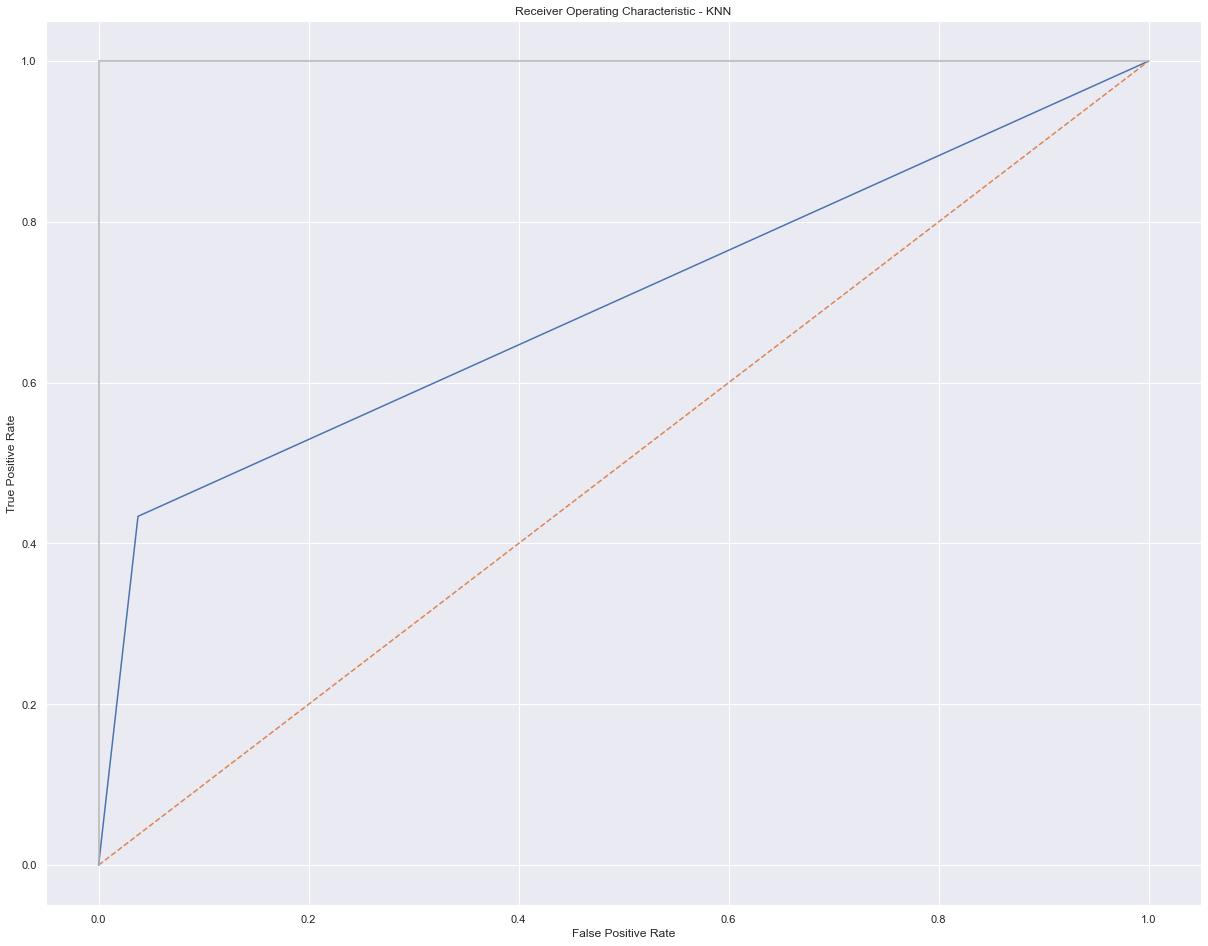

In [85]:
plt.title('Receiver Operating Characteristic - KNN')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [86]:
y_test

array([1, 1, 0, ..., 1, 1, 0])

In [87]:
#Evaluation du modèle KNN: 

#-performances sur les jeux tests et entrainement (évaluation de l'adaptation) 
#bonnes performances au Train qu'au Test donc le modèle s'adapte

#accuracy et F1scores : le modèle est bien plus performant sur le train que sur le test.
# Il y a clairement du surapprentissage

#-matrice de confusion (analyse des performances classe par classe) : 
#Le modèle classe mal les données positives: le modèle dit trop souvent 
#qu'il pleut alors qu'il ne pleut pas.

In [88]:
#alternative à la gridsearcCV : trouver le meilleur nombre de voisins
from sklearn.metrics import accuracy_score


n_voisins = range(1, 50)

score_train = []
score_pred = []
voisin = []

for i in n_voisins:
    model = KNeighborsClassifier(n_neighbors=i)

    model.fit(x_train, y_train)

    y_pred_train = model.predict(x_train)
    y_pred_pred = model.predict(x_test)

    acc_train = accuracy_score(y_train, y_pred_train)
    score_train.append(acc_train)

    acc_pred = accuracy_score(y_test, y_pred_pred)
    score_pred.append(acc_pred)
    voisin.append(i)



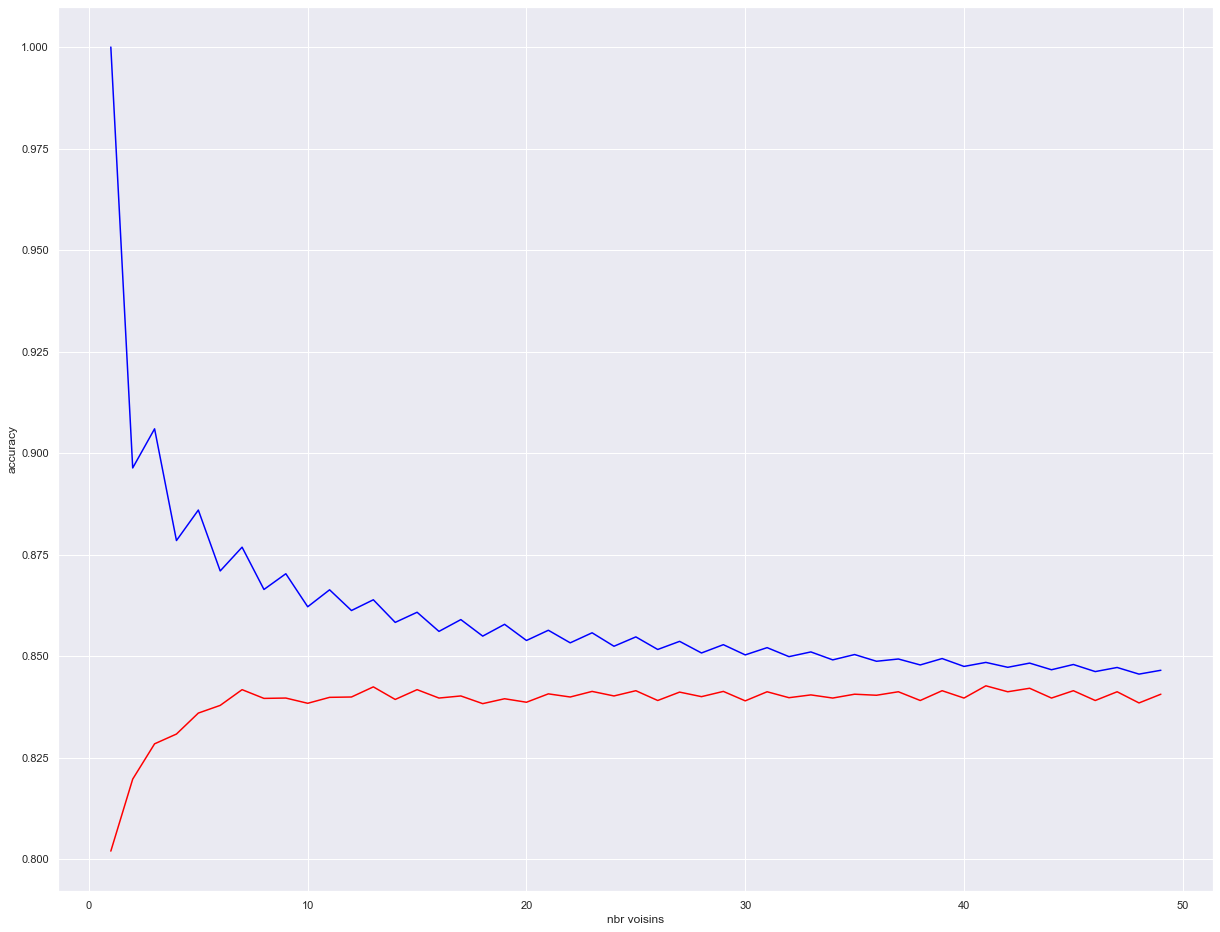

In [89]:
#visualisation de l'accuracy en fonction du nbr de voisins : recherche du meilleur nbr_voisins
plt.plot(voisin, score_train, c = 'blue')
plt.plot(voisin, score_pred, c = 'red')
plt.xlabel('nbr voisins')
plt.ylabel('accuracy')
plt.show()

In [90]:
#on onstate que le nombre de voisins atteint un plateau dès 12 voisins environ. 
# Je vais donc tester avec 11 voisins de façon à eviter le surapprentissage

In [95]:
#maintenant que l'on connait le nbr de voisins idéal, on prédit.

model = KNeighborsClassifier(metric='manhattan', n_neighbors=13) #mettre ici le meilleur nbr_voisins trouvé plus haut
model.fit(x_train,y_train)

y_pred_train_KNN2 = model.predict(x_train)
y_pred_test_KNN2 = model.predict(x_test)

#obtenir l'accuracy
acc_train_KNN2 = accuracy_score(y_train, y_pred_train_KNN2)
acc_test_KNN2 = accuracy_score(y_test, y_pred_test_KNN2)

#obtenir le F1 score
f1score_train_KNN2 = f1_score(y_train, y_pred_train_KNN2, average='macro')
f1score_test_KNN2 = f1_score(y_test, y_pred_test_KNN2, average='macro')

#afficher l'accuracy et F1 score
print("acc_train : ", acc_train_KNN2, "acc_test :", acc_test_KNN2)
print("F1score_train : ", f1score_train_KNN2, "F1score_test : ", f1score_test_KNN2)

#Afficher une matrice de confusion pour comparer les classes réelles et prédites.
#pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

#matrice de confusion
pd.crosstab(y_test, y_pred_test_KNN2, rownames=['Classe réelle'], colnames=['Classe prédite'])


acc_train :  0.8682862799104837 acc_test : 0.844809777930797
F1score_train :  0.7757450478693334 F1score_test :  0.7345853676800816


Classe prédite,0,1
Classe réelle,,
0,8651,408
1,1395,1164


In [96]:
#nous constatons une légère amélioration des performances...
#le sur apprentissage est du à weights='distance'.
#après retrait de ce hyperparamtètre, nous voyons que les performances sur le train collent bien mieux à celles du test.

In [97]:
#Evaluation du modèle KNN: 

#-performances sur les jeux tests et entrainement(évaluation de l'adaptation) 
#bonnes performances au Train qu'au Test donc le modèle s'adapte

#accuracy et F1scores : le modèle est bien plus performant sur le train que sur le test.
# Il y a clairement du surapprentissage

#-matrice de confusion (analyse des performances classe par classe) : 
#Le modèle classe mal les données positives: le modèle dit trop souvent 
#qu'il pleut alors qu'il ne pleut pas.
#Nous retrouvons ce problème pour les 4 premiers modèles testés.

#-Temps (le mieux est le plus court) : 5mn, ce qui est raisonnable.

#ROC et AUC : A finir.


#-améliorations du jeu de données suite aux résultats de l'évaluation? : 
#Trois hypothèses à ce stade sur la cause de ce problème : 
#Il y a trop de variables donc le modèle fait de l'overfitting ((cas connu posible de surdimensionnalité)
#nous pourrons donc tester l'efficacité sur les performances globales de différentes méthodes de 
#réduction de dimension pour valider leur intérêt et éventuellement modifier le modèle final.
#exemple :  ACP.

#outliers : nous déterminerons la meilleure méthode (ou les meilleures) puis nous testerons leur 
#impact sur les performances globales de ce modèle. 

#Le jeu est trop déséquilibré : nous essaierons donc d'autres méthodes de rééchantillonage 
#après une recherche sur les méthodes les plus appropriées.

In [99]:
##Test du modèle KNN avec les meilleurs hyperparamètres 
#avec rééquilibrage du jeu de données par undersampling:

#import des librairies
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids

#Random Undersampling
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(x, y)
print('Classes échantillon undersampled :', dict(pd.Series(y_ru).value_counts()))

#Centroids
#cc = ClusterCentroids()
#X_cc, y_cc = cc.fit_resample(x, y)
#print('Classes échantillon CC :', dict(pd.Series(y_cc).value_counts()))


  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)
  Using cached scikit_learn-1.1.1-cp39-cp39-win_amd64.whl (7.4 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:


ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'c:\\programdata\\anaconda3\\lib\\site-packages\\scikit_learn-1.0.2.dist-info\\COPYING'
Consider using the `--user` option or check the permissions.



ModuleNotFoundError: No module named 'imblearn'

In [ ]:
# réduction du jeu de données, répartition en jeux train et test

x_ru_train, x_ru_test, y_ru_train, y_ru_test = train_test_split(X_ru, y_ru, test_size=0.20, random_state=42)

In [ ]:
#itération du modèle : KNN, avec les données réduites.

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

model = KNeighborsClassifier(metric='manhattan', n_neighbors=11) #mettre ici le meilleur nbr_voisins trouvé plus haut
model.fit(x_ru_train,y_ru_train)

y_pred_train_KNNru = model.predict(x_ru_train)
y_pred_test_KNNru = model.predict(x_ru_test)

#obtenir l'accuracy
acc_train_KNNru = accuracy_score(y_ru_train, y_pred_train_KNNru)
acc_test_KNNru = accuracy_score(y_ru_test, y_pred_test_KNNru)

#obtenir le F1 score
f1score_train_KNNru = f1_score(y_ru_train, y_pred_train_KNNru, average='macro')
f1score_test_KNNru = f1_score(y_ru_test, y_pred_test_KNNru, average='macro')

#afficher l'accuracy et F1 score
print("acc_train : ", acc_train_KNNru, "acc_test :", acc_test_KNNru)
print("F1score_train : ", f1score_train_KNNru, "F1score_test :", f1score_test_KNNru)

#matrice de confusion

pd.crosstab(y_ru_test, y_pred_test_KNNru, rownames=['Classe réelle'], colnames=['Classe prédite'])


In [ ]:
#conclusion du test de l'udersampling :
#Néanmoins, on voit une baisse de l'accuracy et une légère hausse du F1 score.
#Le point le plus interessant est la matrice de confusion :
#  on constate une hausse du classement en faux négatifs, et une chute du classement en faux postifs

In [ ]:
##Test du modèle KNN avec les meilleurs hyperparamètres 
#avec rééquilibrage du jeu de données par oversampling SMOTE:

#SMOTE
smo = SMOTE()
x_sm, y_sm = smo.fit_resample(x, y)
print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))

In [ ]:
# réduction du jeu de données, répartition en jeux train et test

x_sm_train, x_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, test_size=0.20, random_state=42)

In [ ]:
#itération du modèle : KNN, avec les données réduites.

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

model = KNeighborsClassifier(metric='manhattan', n_neighbors=11) #mettre ici le meilleur nbr_voisins trouvé plus haut
model.fit(x_sm_train,y_sm_train)

y_pred_train_KNNsm = model.predict(x_sm_train)
y_pred_test_KNNsm = model.predict(x_sm_test)

#obtenir l'accuracy
acc_train_KNNsm = accuracy_score(y_sm_train, y_pred_train_KNNsm)
acc_test_KNNsm = accuracy_score(y_sm_test, y_pred_test_KNNsm)

#obtenir le F1 score
f1score_train_KNNsm = f1_score(y_sm_train, y_pred_train_KNNsm, average='macro')
f1score_test_KNNsm = f1_score(y_sm_test, y_pred_test_KNNsm, average='macro')

#afficher l'accuracy et F1 score
print("acc_train : ", acc_train_KNNsm, "acc_test :", acc_test_KNNsm)
print("F1score_train : ", f1score_train_KNNsm, "F1score_test :", f1score_test_KNNsm)

#matrice de confusion

pd.crosstab(y_ru_test, y_pred_test_KNNsm, rownames=['Classe réelle'], colnames=['Classe prédite'])

In [ ]:
#conclusion sur l'oversampling SMOTE

In [100]:
#Test de l'hypothèse de feature selection plus drastique (eventuellement combiné à l'oversampling)
'''
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel

#Instancier un modèle de régression linéaire lr.
clf = KNeighborsClassifier(metric='manhattan', n_neighbors=13) #mettre ici le meilleur nbr_voisins trouvé plus haut
clf.fit(x_train,y_train)

#Créer un sélecteur sfm instance de la classe SelectFromModel, à partir du modèle lr créé.
sfm = SelectFromModel(clf)

sfm_train = sfm.fit_transform(x_train, y_train)

sfm_test = sfm.transform(x_test)


# Afficher les noms des colonnes sélectionnés par sfm grâce à la méthode get_support.
x_train.columns[sfm.get_support()]

'''



 


ValueError: when `importance_getter=='auto'`, the underlying estimator KNeighborsClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [ ]:
# Afficher les noms des colonnes sélectionnés par sfm grâce à la méthode get_support.
'''
cols = sfm.get_support(indices=True)
features_reduced = x.iloc[:,cols]

features_reduced.head()
'''

In [ ]:
#relance du KNN avec hyperparamètres identiques, et x remplacés par features_reduced
'''
model = KNeighborsClassifier(metric='manhattan', n_neighbors=29, weights='distance') #mettre ici le meilleur nbr_voisins trouvé plus haut
model.fit(sfm_train,y_train)

y_pred_train = model.predict(sfm_train)
y_pred_test = model.predict(sfm_test)

#obtenir l'accuracy
acc_train_KNNsfm = accuracy_score(y_train, y_pred_train)
acc_test_KNNsfm = accuracy_score(y_test, y_pred_test)

#obtenir le F1 score
f1score_train_KNNsfm = f1_score(y_train, y_pred_train, average='macro')
f1score_test_KNNsfm = f1_score(y_test, y_pred_test, average='macro')

#afficher l'accuracy et F1 score
print("acc_train : ", acc_train_KNNsfm, "acc_test :", acc_test_KNNsfm)
print("F1score_train : ", f1score_train_KNNsfm, "F1score_test :", f1score_test_KNNsfm)

#matrice de confusion

pd.crosstab(y_test, y_pred_test, rownames=['Classe réelle'], colnames=['Classe prédite'])
crosstab_KNNsfm = pd.crosstab(y_test, y_pred_test, rownames=['Classe réelle'], colnames=['Classe prédite'])
'''

In [ ]:
#conclusion du test de l'aternative 2 :

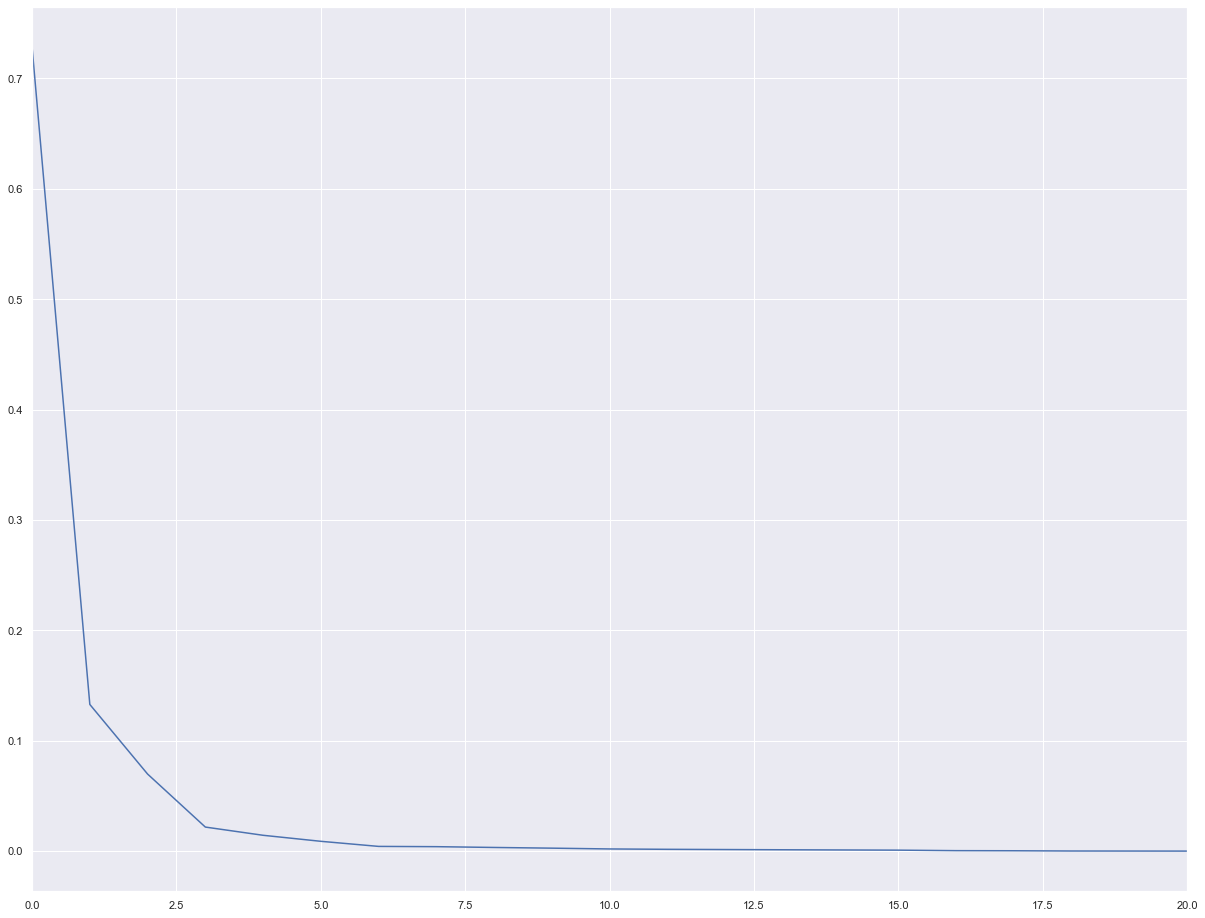

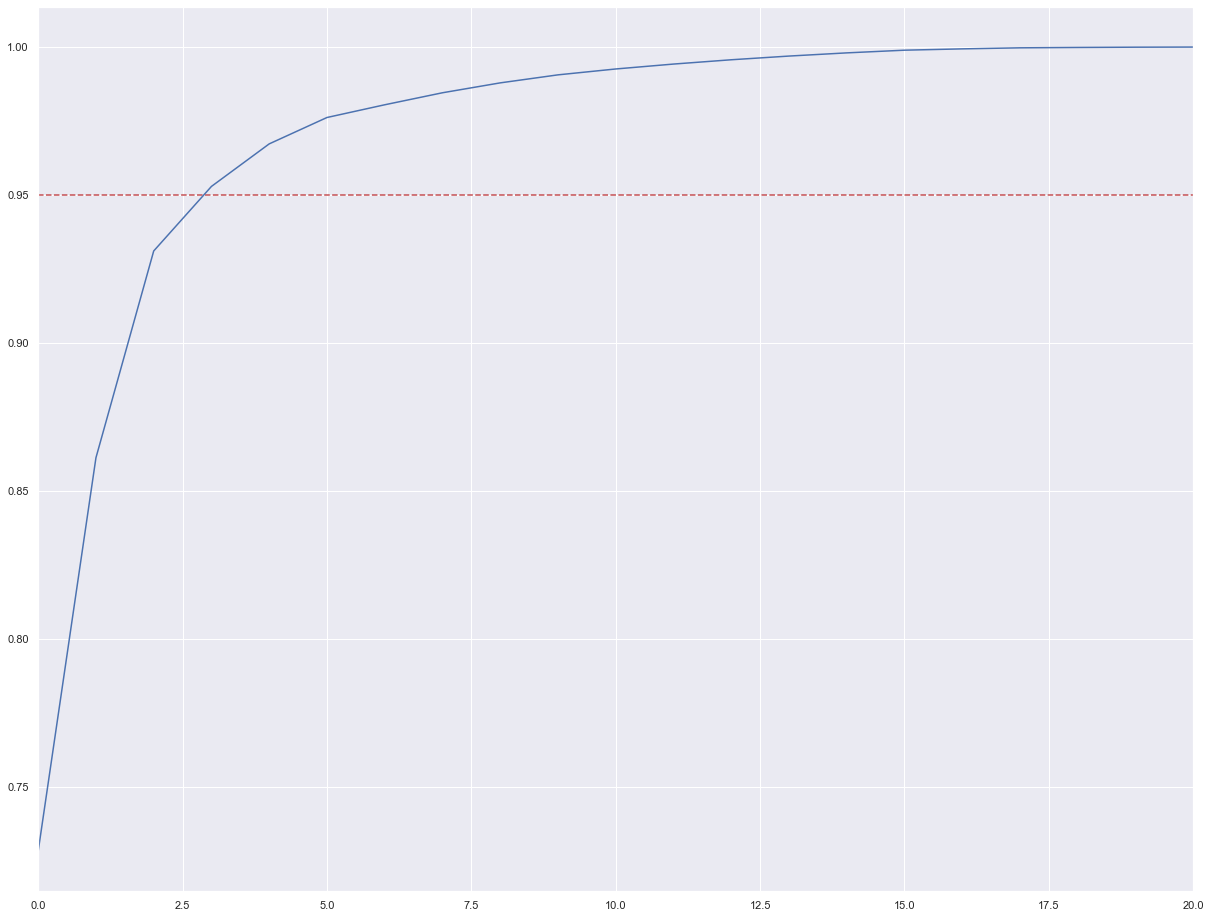

In [101]:
#alternative de resampling 3 : réduction de la complexité via ACP et relance

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train)

plt.figure()
plt.xlim(0,20)
plt.plot(pca.explained_variance_ratio_);

plt.figure()
plt.xlim(0,20)
plt.axhline(y = 0.95, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());

In [102]:
#réduction de x_train et x_test via ACP

pca = PCA(n_components = 0.90)    #à déterminer selon résultat ci dessus
#(n_components = 0.90) = nbr de composantes pour conserver 90% de la variance expliquée cumulée

x_train_pca = pca.fit_transform(x_train)
print("Nombre de composantes retenues :", pca.n_components_)

x_test_pca = pca.transform(x_test)

Nombre de composantes retenues : 3


In [103]:
#relance du KNN avec hyperparamètres identiques, et x remplacés par x_pca

model = KNeighborsClassifier(metric='manhattan', n_neighbors=11) #mettre ici le meilleur nbr_voisins trouvé plus haut
model.fit(x_train_pca, y_train)

y_pred_train_pca = model.predict(x_train_pca)
y_pred_test_pca = model.predict(x_test_pca)

#obtenir l'accuracy
acc_train_KNNpca = accuracy_score(y_train, y_pred_train_pca)
acc_test_KNNpca = accuracy_score(y_test, y_pred_test_pca)

#obtenir le F1 score
f1score_train_KNNpca = f1_score(y_train, y_pred_train_pca, average='macro')
f1score_test_KNNpca = f1_score(y_test, y_pred_test_pca, average='macro')

#afficher l'accuracy et F1 score
print("acc_train : ", acc_train_KNNpca, "acc_test :", acc_test_KNNpca)
print("F1score_train : ", f1score_train_KNNpca, "F1score_test :", f1score_test_KNNpca)

#matrice de confusion

pd.crosstab(y_test, y_pred_test_pca, rownames=['Classe réelle'], colnames=['Classe prédite'])


acc_train :  0.8165346875537959 acc_test : 0.7940265105870201
F1score_train :  0.6546765771126563 F1score_test : 0.6156282963614108


Classe prédite,0,1
Classe réelle,,
0,8570,489
1,1904,655


In [104]:
#conclusion du test de réduction de dimensions via ACP
# en terme d'accuracy et de F1score, perte de performances sur le train, mais maintien des perfs sur le test.
#le surapprentissage est éliminé
#pas de gain en terme de pertinence du classement


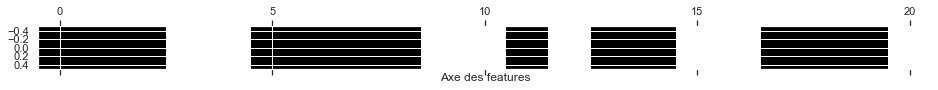

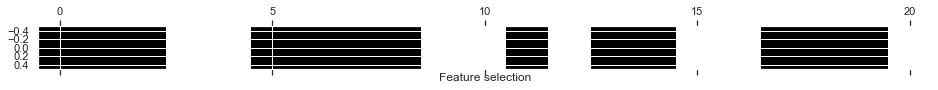

In [115]:
#alternative de resampling 4 : threshold via un VarianceThreshold

#Créer un sélecteur VarianceThreshold appelé sel avec un threshold de 1e-6.
sel = VarianceThreshold(threshold = 0.95)

# Ajuster ce sélecteur sur le jeu d'entrainement.
sel.fit(x_train);

#Récupérer le masque du sélecteur dans une variable mask.
mask = sel.get_support()

#Exécuter le code de la cellule pour afficher une représentation des features conservées.
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
#matshow permet d'afficher un array numpy sous la forme d'une matrice
plt.xlabel('Axe des features');

#Décommentez les lignes ci dessous avant d'exécuter votre code
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Feature selection');

In [116]:
#Sauvegarder le jeu d'entrainement et le jeu de test dans des variables X_train_save et X_test_save. Nous y reviendrons plus tard
X_train_save = x_train
X_test_save = x_test

# Supprimer les features de variance nulle des jeux d'entrainement et de test à l'aide de la méthode transform du sélecteur.
x_train_sel = sel.transform(x_train)
x_test_sel = sel.transform(x_test)

In [117]:
x_train_sel.shape

(46472, 13)

In [118]:
x_train.shape

(46472, 21)

In [119]:
#relance du KNN avec hyperparamètres identiques, et x remplacés par x_sel

model = KNeighborsClassifier(metric='manhattan', n_neighbors=13) #mettre ici le meilleur nbr_voisins trouvé plus haut
model.fit(x_train_sel, y_train)

y_pred_train_sel = model.predict(x_train_sel)
y_pred_test_sel = model.predict(x_test_sel)

#obtenir l'accuracy
acc_train_KNNsel = accuracy_score(y_train, y_pred_train_sel)
acc_test_KNNsel = accuracy_score(y_test, y_pred_test_sel)

#obtenir le F1 score
f1score_train_KNNsel = f1_score(y_train, y_pred_train_sel, average='macro')
f1score_test_KNNsel = f1_score(y_test, y_pred_test_sel, average='macro')

#afficher l'accuracy et F1 score
print("acc_train : ", acc_train_KNNsel, "acc_test :", acc_test_KNNsel)
print("F1score_train : ", f1score_train_KNNsel, "F1score_test :", f1score_test_KNNsel)

#matrice de confusion

pd.crosstab(y_test, y_pred_test_sel, rownames=['Classe réelle'], colnames=['Classe prédite'])

acc_train :  0.8590764331210191 acc_test : 0.8393010845240144
F1score_train :  0.7551667691776928 F1score_test : 0.7189302148056591


Classe prédite,0,1
Classe réelle,,
0,8677,382
1,1485,1074


In [120]:
#conclusion du resampling 4 : threshold via un VarianceThreshold
#il est nécéssaire d'ajuster le threshold afin de conserver de bonnes performances.
#néanmoins, nous constations une baisse des performances (accuracy et f1score)
#ainsi qu'une déterioration du classement des faux positifs.
#  Par contre, il y a une légère amélioration du classement des faux négatifs.
# abaisser le seuil en dessous de 1 (augmentation du nbr de features retenues) 
# rapproche les performances de celles du modèle de base

In [121]:
#conclusion sur le KNN : 
#Le KNN n'offre pas des performances satisfaisantes. Il est nécéssaire de tester d'autres modèles.

In [122]:
### scénario 3 : un arbre de décision

# Création d'un modèle d'arbre de décision

from sklearn.tree import DecisionTreeClassifier 

for mdepth, crt in zip ([2,3,4,5,6,7,8,9], ["gini", "entropy"]):
    dtc = DecisionTreeClassifier(criterion = crt, max_depth = mdepth, random_state = 123)
    dtc.fit(x_train, y_train)
    y_pred_train_arbre = dtc.predict(x_train)
    y_pred_test_arbre = dtc.predict(x_test)
    

#obtenir l'accuracy
acc_train_arbre = accuracy_score(y_train, y_pred_train_arbre)
acc_test_arbre = accuracy_score(y_test, y_pred_test_arbre)

#obtenir le F1 score
f1score_train_arbre = f1_score(y_train, y_pred_train_arbre, average='macro')
f1score_test_arbre = f1_score(y_test, y_pred_test_arbre, average='macro')

#afficher l'accuracy et F1 score
print("acc_train : ", acc_train_arbre, "acc_test :", acc_test_arbre)
print("F1score_train : ", f1score_train_arbre, "F1score_test :", f1score_test_arbre)

print(pd.crosstab(y_test, y_pred_test_arbre, rownames = ["Classe_réelle"], colnames = ["Classe_prédite"]))

acc_train :  0.840398519538647 acc_test : 0.8316405577552074
F1score_train :  0.7226086313438275 F1score_test : 0.7078851244207784
Classe_prédite     0     1
Classe_réelle             
0               8612   447
1               1509  1050


In [123]:
variable_importance = {}
for feature, importance, in zip(df_bourrin.columns, dtc.feature_importances_):
    variable_importance[feature] = importance

ClassementImportant = pd.DataFrame.from_dict(variable_importance, orient = "index").rename(columns = {0 : "importance"})

print(ClassementImportant.sort_values(by = "importance", ascending = False).head(7))


               importance
Humidity3pm      0.688721
Sunshine         0.172697
Pressure3pm      0.098722
WindGustSpeed    0.039860
Location         0.000000
month            0.000000
Temp3pm          0.000000


In [124]:
"""
On voit bien que seules 4 variables sont importantes selon ce modèle. La plus importatnte est bien "Humidity3pm" () l'humidité
 à 3h de l'après midi) tandis que la moins importante des 4 est bien "Cloud3pm"

On voit aussi que les autres variables explicatives n'influent quasiment pas notre variable cible ("RunTomorow")
"""

'\nOn voit bien que seules 4 variables sont importantes selon ce modèle. La plus importatnte est bien "Humidity3pm" () l\'humidité\n à 3h de l\'après midi) tandis que la moins importante des 4 est bien "Cloud3pm"\n\nOn voit aussi que les autres variables explicatives n\'influent quasiment pas notre variable cible ("RunTomorow")\n'

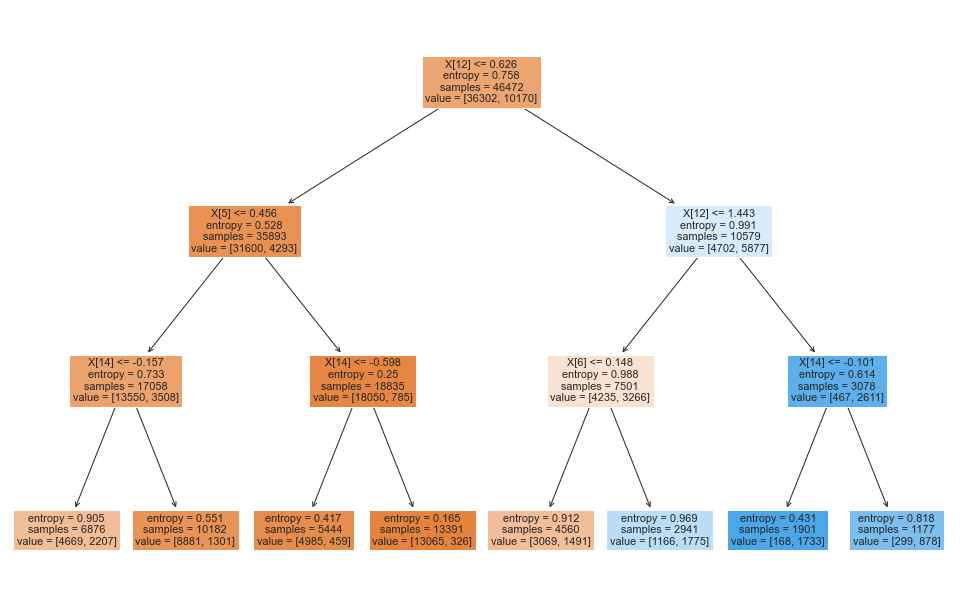

In [125]:
# Affichons notre abre de décision
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize = (17,11))
plot_tree(dtc, filled = True)
plt.show();

In [126]:
#conclusion sur l'arbre de décision : 
#L'arbre de décision n'offre pas des performances satisfaisantes. Il est nécéssaire de tester un autre modèle.

In [127]:
###scénario 3 : Régression logistique

##a)test de la regression logistique sans oversampling : 

#Nous testons la regression logistique puisque ce modèle est plus simple
#et certains modèles testés comme le SVC linéaire prennent beaucoup de temps, 
#nous voulons comparer les résultats de performances avec des modèles plus courts en temps

In [128]:
#Nous lançons une GridSearch pour optimiser les hyperparamètres du modèle avant de l'évaluer sur ses paramètres optimisés: 
#plus le C est grand plus la régularisation est faible.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] , "penalty":["l1","l2"]}# l1 lasso l2 ridge}
gs = GridSearchCV(LogisticRegression(), params, verbose = 1, cv = 10)
gs.fit(x_train, y_train)
display(print(gs.best_score_))
display(print(gs.best_estimator_))
display(print(gs.best_params_))

#finir interprétation : les intercept etc et graphe des scores par C.
#et comme les autres.
#finir les intepreétations spécifiques pour ce modèle logreg (les intercep, pes probs
#etc voir le cours) et les mêmes inteprrétations que preparées pour SVC pour lundi.

#Analyse des résultats : le temps est très court et le score est comparable à la SVC sans oversampling. 
#Nous n'avons pas comparé avec tous les modèles pour le moment mais c'est
#pour le moment un modèle qui semble parmi les meilleurs sur l'ensemble des critères de choix
#(temps, score, interprétabilité).

Fitting 10 folds for each of 14 candidates, totalling 140 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.8573550635262622


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan 0.85244889        nan 0.85612847        nan 0.85679555
        nan 0.8564513         nan 0.85713986        nan 0.85735506
        nan 0.856774  ]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


None

LogisticRegression(C=100)


None

{'C': 100, 'penalty': 'l2'}


None

In [ ]:

#Puis on lance le meilleur modèle : 

#Tout d'abord nous lançons un modèle simple avec un C intermédiaire , 1, afin d'avoir des 
#premiers résultats rapidement et voir le temps mis avant de passer à une gridsearch :

#(date :  15/07/2022)

log_regb = LogisticRegression(C=0.01, penalty= 'l2')
log_regb.fit(x_train, y_train)

#évaluation du  modèle : 
print('coef :', log_regb.coef_)
print('intercept :', log_regb.intercept_)

#matrice de confusion
#...
print("score du modèle : ", log_regb.score(x_test, y_test))
y_pred = log_regb.predict(x_test)
#from sklearn.metrics import confusion_matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

probs = log_regb.predict_proba(x_test)   # Calcul des probabilité d'appartenir à une classe donnée
y_probs_pred = np.where(probs[:,1]>0.4,1,0)   # vecteur composé que de 1 (si probs[i] > 40 %) et ou de 0 (si probs <40 %)

# Matrice de confusion calculée en fonction de y_probs_pred et de y_test
mat_conf = pd.crosstab(y_test, y_probs_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

print(mat_conf)
# Importation des packages roc_curve (permettant de calculer l'antispécificité, la sensibilité et le seuil) et 
# auc (permettant de calculer l'aire sous la courbe en fonction des taux de prédictions.)
from sklearn.metrics import roc_curve, auc  

fpr, tpr, seuils = roc_curve(y_test, probs[:,1], pos_label=1)      # Pour le calcul des taux de prédictions et le seuil 
#roc_auc = auc(fpr, tpr)      # Pour le calcul de l'aire sous la courbe



In [ ]:
##b) LogReg avec Oversampling pour correction du désequilibre de la répartition des données dans les modalités de RainTomorrow
##Test du modèle SVM avec les meilleurs hyperparamètres 
#avec rééquilibrage du jeu de données par undersampling:

#import des librairies
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids

#Random Undersampling
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(x, y)
print('Classes échantillon undersampled :', dict(pd.Series(y_ru).value_counts()))

#Centroids
#cc = ClusterCentroids()
#X_cc, y_cc = cc.fit_resample(x, y)
#print('Classes échantillon CC :', dict(pd.Series(y_cc).value_counts()))
#après réduction du jeu de données, répartition en jeux train et test
x_ru_train, x_ru_test, y_ru_train, y_ru_test = train_test_split(X_ru, y_ru, test_size=0.20, random_state=42)

#(date :  15/07/2022)
log_regb = LogisticRegression(C=100, penalty= 'l2')
log_regb.fit(x_ru_train, y_ru_train)

#évaluation du  modèle : 
print('coef', log_regb.coef_)
print('intercept', log_regb.intercept_)

#matrice de confusion
#...
print(log_regb.score(x_ru_test, y_ru_test))
y_pred = log_regb.predict(x_ru_test)
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_ru_test,y_pred)
print(cm)

#conclusion la méthode d'oversampling baisse le score mais permet de mieux
#prédire la deuxième classe.
#Nous testons à présent d'autres méthodes de rééchantillonnage.

In [ ]:
##création et analyse du graphique du ROC (courbe TP en fonction de FP) et de AUC : 
#RO indique ...
#AUC est un nombre qui mesure la performance du modèle
# Un score AUC de 0.5 signifie que le modèle n'est pas meilleur qu'une classification aléatoire, un score AUC de 1.0 signifie un
# modèle parfaitement prédictif tandisqu'un AUC égale à 0 est parfaitement anti-prédictif (très rare).


""" 
En utilisant la méthode predict_proba alcul des probabilités d'appartenir à une classe donnée. Cela va nous permettre
de jouer sur le seuil. On pourrait soit le baisser à moins de 50 % ou à le rehausser à plus de 50 %. Sachant que que 
50 % est le seuil par défaut de la méthode "predict()" d'un classifieur dans le cas d'une régression logistic.
"""
probs = log_regb.predict_proba(X_test)

""" Ecrivons le vecteur "y_probs_pred" qui, pour chaque ligne de probs vaut 1 si la probabilité d'appartenir
à la classe 1 est supérieure à 0.4, et 0 sinon.
"""

y_probs_pred = np.where(probs[:,1]>0.4,1,0)

# Affichons la matrice de confusion entre les vrais labels "y_test" et "y_probs_pred" pour juger la performance du modèle

mat_conf = pd.crosstab(y_test, y_probs_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

"""
Utilison la fonction roc_curve pour calculer, dans un tabeau, l'antispécificité (les taux de faux positifs) et
la sensibilité (taux de vrai posistifs) et le seuil
Par la suite on calculera à l'aide de la fonction "auc()" l'aire sous la courbe. Cette fonction va prendre en 
argument l'antispécificité et la sensibilité
"""
from sklearn.metrics import roc_curve, auc

fpr, tpr, seuils = roc_curve(y_test, probs[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

""" Construction de la figure de la courbe de ROC pour visualiser la capacité du modèle à nous dire s'il ou non pleuvoir demain
"""
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, color='orange', lw=2, label='Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show();

In [129]:
## scénario 4 : une random forest classifier
from sklearn.ensemble import RandomForestClassifier

#recherche des meilleurs hyperparamètres via gridsearchCV

params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

gs = GridSearchCV(RandomForestClassifier(), params, verbose = 1, cv = 5)

gs.fit(x_train, y_train)

display(print(gs.best_score_))
display(print(gs.best_estimator_))
display(print(gs.best_params_))

##la computation prend du temps... résultat de la gridsearchCV pour random forest :  
# Autre possibilité : utiliser un script simplifié pour déterminer le meilleur nombre de voisins.



Fitting 5 folds for each of 60 candidates, totalling 300 fits
0.8563651226858259


None

RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt',
                       n_estimators=500)


None

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}


None

In [130]:
#temps d'execution de la gridsearchCV : environ 2H - 2H30
#meilleurs paramètres : {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}

In [131]:
#maintenant que l'on connait les meilleurs hyperparamètres

model = RandomForestClassifier(max_depth = 8, n_estimators =500, criterion = 'entropy', max_features = 'sqrt') #mettre ici le meilleur nbr_voisins trouvé plus haut
model.fit(x_train,y_train)

y_pred_train_Rforest1 = model.predict(x_train)
y_pred_test_Rforest1 = model.predict(x_test)

#obtenir l'accuracy
acc_train_Rforest1 = accuracy_score(y_train, y_pred_train_Rforest1)
acc_test_Rforest1 = accuracy_score(y_test, y_pred_test_Rforest1)

#obtenir le F1 score
f1score_train_Rforest1 = f1_score(y_train, y_pred_train_Rforest1, average='macro')
f1score_test_Rforest1 = f1_score(y_test, y_pred_test_Rforest1, average='macro')

#afficher l'accuracy et F1 score
print("acc_train : ", acc_train_Rforest1, "acc_test :", acc_test_Rforest1)
print("F1score_train : ", f1score_train_Rforest1, "F1score_test : ", f1score_test_Rforest1)

#Afficher une matrice de confusion pour comparer les classes réelles et prédites.
#pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

#matrice de confusion
pd.crosstab(y_test, y_pred_test_Rforest1, rownames=['Classe réelle'], colnames=['Classe prédite'])

acc_train :  0.8664787398863832 acc_test : 0.8467894646238595
F1score_train :  0.7704997789530734 F1score_test :  0.734272796253264


Classe prédite,0,1
Classe réelle,,
0,8699,360
1,1420,1139


In [132]:
#conclusion sur la random forest : 
#les performances tant en terme d'accuracy que de f1score sont similaires à la logreg.
#les performances en terme de classement ne diffèrent pas des KNN...
#

In [133]:
#conclusion du test sur df_bourrin

#rappel des performandes des différents modèles et hypothèses testées

#KNN 1 : (metric='manhattan', n_neighbors=29, weights='distance') 

#afficher l'accuracy et F1 score
print("scores du KNN gridsearch")
print("acc_train : ", acc_train_KNN1, "acc_test :", acc_test_KNN1)
print("F1score_train : ", f1score_train_KNN1, "F1score_test : ", f1score_test_KNN1)
print(pd.crosstab(y_test, y_pred_test_KNN1, rownames = ["Classe_réelle"], colnames = ["Classe_prédite"]))

#KNN 2 : (metric='manhattan', n_neighbors=11)
print("scores du KNN à 11 voisins")
print("acc_train : ", acc_train_KNN2, "acc_test :", acc_test_KNN2)
print("F1score_train : ", f1score_train_KNN2, "F1score_test : ", f1score_test_KNN2)
print(pd.crosstab(y_test, y_pred_test_KNN2, rownames = ["Classe_réelle"], colnames = ["Classe_prédite"]))

#KNN avec undersampling : (metric='manhattan', n_neighbors=11)
print("scores du KNN à 11 voisins avec undersampling")
print("acc_train : ", acc_train_KNNru, "acc_test :", acc_test_KNNru)
print("F1score_train : ", f1score_train_KNNru, "F1score_test :", f1score_test_KNNru)
print(pd.crosstab(y_test, y_pred_test_KNNru, rownames = ["Classe_réelle"], colnames = ["Classe_prédite"]))

#KNN avec oversampling SMOTE : (metric='manhattan', n_neighbors=11)
print("scores du KNN à 11 voisins avec oversampling SMOTE")
print("acc_train : ", acc_train_KNNsm, "acc_test :", acc_test_KNNsm)
print("F1score_train : ", f1score_train_KNNsm, "F1score_test :", f1score_test_KNNsm)
pd.crosstab(y_ru_test, y_pred_test_KNNsm, rownames=['Classe réelle'], colnames=['Classe prédite'])

#KNN avec acp : (metric='manhattan', n_neighbors=11)
print("scores du KNN à 11 voisins avec acp")
print("acc_train : ", acc_train_KNNpca, "acc_test :", acc_test_KNNpca)
print("F1score_train : ", f1score_train_KNNpca, "F1score_test :", f1score_test_KNNpca)
print(pd.crosstab(y_test, y_pred_test_KNNpca, rownames = ["Classe_réelle"], colnames = ["Classe_prédite"]))

#KNN avec selection de variablkes via threshold : (metric='manhattan', n_neighbors=11)(threshold = 0.96)
print("scores du KNN à 11 voisins avec selection de variables via threshold (seuil = 0.96)")
print("acc_train : ", acc_train_KNNsel, "acc_test :", acc_test_KNNsel)
print("F1score_train : ", f1score_train_KNNsel, "F1score_test :", f1score_test_KNNsel)
print(pd.crosstab(y_test, y_pred_test_KNNsel, rownames = ["Classe_réelle"], colnames = ["Classe_prédite"]))

#arbre de décision
print("scores de l'arbre de décision")
print("acc_train : ", acc_train_arbre, "acc_test :", acc_test_arbre)
print("F1score_train : ", f1score_train_arbre, "F1score_test :", f1score_test_arbre)
print(pd.crosstab(y_test, y_pred_test_arbre, rownames = ["Classe_réelle"], colnames = ["Classe_prédite"]))

#logreg


#random forest
print("scores de la foret aléatoire")
print("acc_train : ", acc_train_Rforest1, "acc_test :", acc_test_Rforest1)
print("F1score_train : ", f1score_train_Rforest1, "F1score_test : ", f1score_test_Rforest1)
pd.crosstab(y_test, y_pred_test_Rforest1, rownames=['Classe réelle'], colnames=['Classe prédite'])

#quel est le meilleur modèle ?
#en terme de performances accuracy et f1score, le meilleur semble etre la foret aléatoire
#en terme de performances sur le classement, la logreg semble etre le meilleur modèle.

scores du KNN gridsearch
acc_train :  1.0 acc_test : 0.8460148046135307
F1score_train :  1.0 F1score_test :  0.7303539081587156
Classe_prédite     0     1
Classe_réelle             
0               8719   340
1               1449  1110
scores du KNN à 11 voisins
acc_train :  0.8682862799104837 acc_test : 0.844809777930797
F1score_train :  0.7757450478693334 F1score_test :  0.7345853676800816
Classe_prédite     0     1
Classe_réelle             
0               8651   408
1               1395  1164
scores du KNN à 11 voisins avec undersampling


NameError: name 'acc_train_KNNru' is not defined

In [ ]:
#stratégie subtile 1 : on vite les colonnes infestées de nan, et on compte pour vérifier

df_subtil1 = df.drop(axis = 1, labels = ['Evaporation', 'Cloud9am', 'Cloud3pm'])

#un shape

df_subtil1.shape


In [ ]:
df_subtil1.head()

In [ ]:
#count plot pour estimer la répartition de notre target.

sns.countplot(data = df_subtil1, x = 'RainTomorrow_encode')

In [ ]:
#df_subtil1 : etude des nans

#verification : recherche des nans
df_subtil1.isna().sum()

In [134]:
#scenario 3 : fillna

df_subtil2 = df.fillna(df.mean())

df_subtil2 = pd.DataFrame(df_subtil2)
#for column_name in df_subtil2.columns:
#    df_subtil2[column_name].fillna(df_subtil2[column_name].mode(), inplace=True)


#verification : recherche des nans
df_subtil2.isna().sum()


Location               0
MinTemp                0
MaxTemp                0
Rainfall               0
Evaporation            0
Sunshine               0
WindGustSpeed          0
WindDir9am             0
WindDir3pm             0
WindSpeed9am           0
WindSpeed3pm           0
Humidity9am            0
Humidity3pm            0
Pressure9am            0
Pressure3pm            0
Cloud9am               0
Cloud3pm               0
Temp9am                0
Temp3pm                0
month                  0
RainToday_encode       0
RainTomorrow_encode    0
dtype: int64

In [135]:
df_subtil2.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,month,RainToday_encode,RainTomorrow_encode
0,2,0.189528,-0.045912,-0.206727,-1.860297e-15,-1.179415e-15,0.295517,13,14,0.674441,0.609137,0.113179,-1.417590,-1.400863,-1.159388,1.234088e+00,-1.924722e-14,-0.013478,0.016254,1.633581,0,0
1,2,-0.747494,0.263181,-0.277606,-1.860297e-15,-1.179415e-15,0.295517,6,15,-1.124665,0.381950,-1.304053,-1.273343,-0.992725,-1.059908,2.344824e-14,-1.924722e-14,0.032727,0.376611,1.633581,0,0
2,2,0.111443,0.347479,-0.277606,-1.860297e-15,-1.179415e-15,0.442698,13,15,0.561997,0.836324,-1.618994,-1.032932,-1.414937,-0.932007,2.344824e-14,-9.200734e-01,0.617989,0.218054,1.633581,0,0
3,2,-0.466387,0.670622,-0.277606,-1.860297e-15,-1.179415e-15,-1.176289,9,0,-0.337556,-1.094767,-1.251563,-1.706083,-0.007566,-0.349343,2.344824e-14,-1.924722e-14,0.171342,0.693725,1.633581,0,0
4,2,0.829827,1.274759,-0.159474,-1.860297e-15,-1.179415e-15,0.074746,1,7,-0.787332,0.154763,0.690569,-0.888685,-0.964578,-1.315712,8.877074e-01,1.285309e+00,0.125137,1.154982,1.633581,0,0


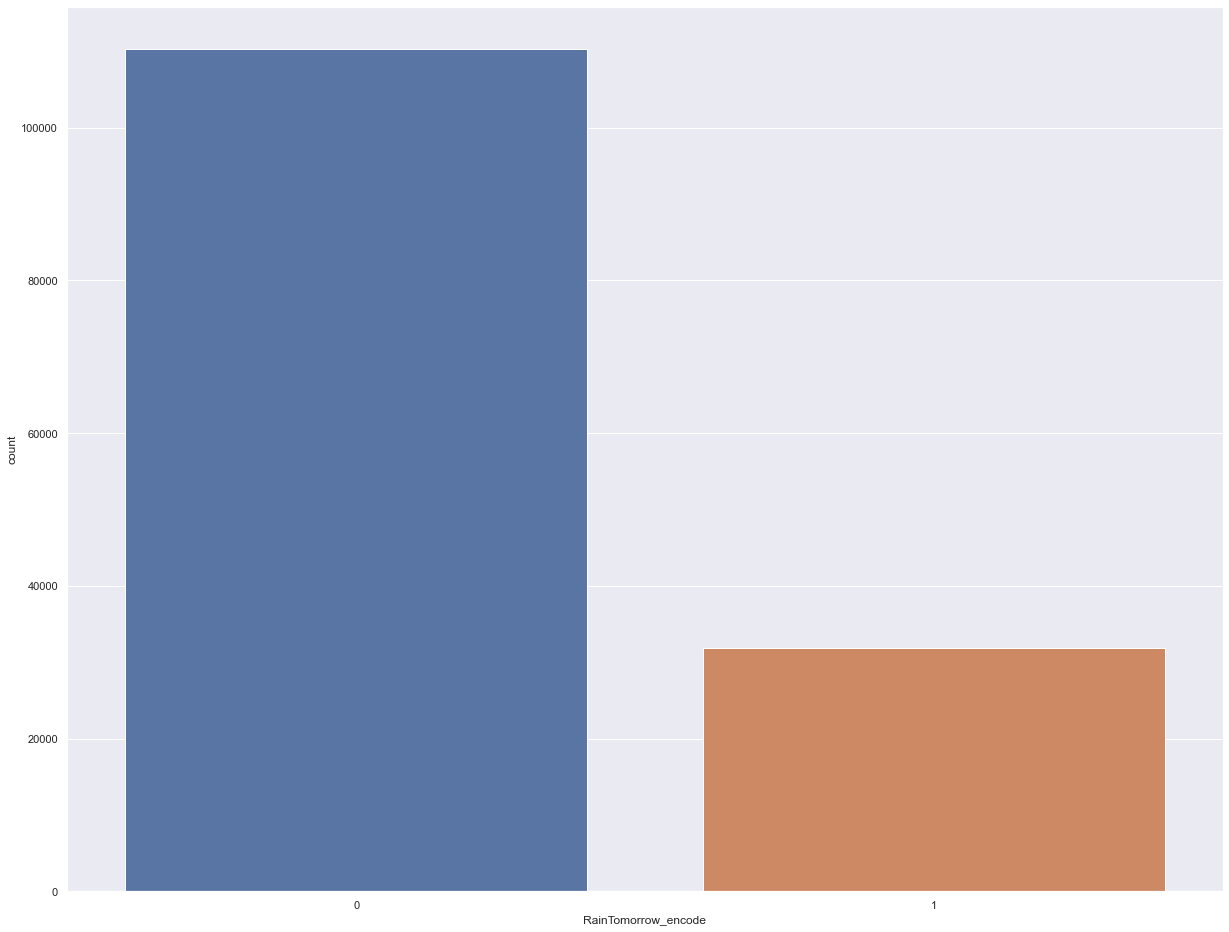

In [136]:
#vérification de la répartition des valeurs dans les 2 modalités de la variable cible , 
#via un count plot.
#Analyse : la répartition est toujours déséquilibrée.
sns.countplot(data = df_subtil2, x = 'RainTomorrow_encode');

In [ ]:
##enelever des outliers sur les variables repérées : (phase après le 5/7)
#comment on fait????? : protocole, méthode? (pour plus tard)

In [137]:
##découpage du jeu de données :


y = df_subtil2['RainTomorrow_encode']
x = df_subtil2.drop('RainTomorrow_encode', axis = 1)
print(x)

        Location   MinTemp   MaxTemp  Rainfall   Evaporation      Sunshine  \
0              2  0.189528 -0.045912 -0.206727 -1.860297e-15 -1.179415e-15   
1              2 -0.747494  0.263181 -0.277606 -1.860297e-15 -1.179415e-15   
2              2  0.111443  0.347479 -0.277606 -1.860297e-15 -1.179415e-15   
3              2 -0.466387  0.670622 -0.277606 -1.860297e-15 -1.179415e-15   
4              2  0.829827  1.274759 -0.159474 -1.860297e-15 -1.179415e-15   
...          ...       ...       ...       ...           ...           ...   
145454        41 -1.356559 -0.200459 -0.277606 -1.860297e-15 -1.179415e-15   
145455        41 -1.465878  0.024336 -0.277606 -1.860297e-15 -1.179415e-15   
145456        41 -1.340942  0.291280 -0.277606 -1.860297e-15 -1.179415e-15   
145457        41 -1.059835  0.516076 -0.277606 -1.860297e-15 -1.179415e-15   
145458        41 -0.685026  0.530125 -0.277606 -1.860297e-15 -1.179415e-15   

        WindGustSpeed  WindDir9am  WindDir3pm  WindSpeed9am  Wi

In [138]:
#reformatage des dimensions de y pour permettre de rentrer les données dans traintestsplit :

y = np.array(y)
y.reshape(-1, 1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [139]:
##Découpage des données en jeu d'entrainement et jeu test pour
#permettre d'évaluer la performance globale des modèles sur un jeu nouveau,
#à hauteur de 20 % des données en test, avec en paramètre randomstate=42 rempli pour la reproductibilité 
#des résultats :
y = y.astype(float)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [140]:
#vérifions la séparation : la séparation a été correctement effectuée (20%).
x_train.shape

(113754, 21)

In [141]:
#vérifions si y_test contient bien les deux valeurs de RainTomorrow_encodeet son type : c'est bon
y_test_verif = pd.Series(y_test)
y_test_verif.value_counts()

0.0    22098
1.0     6341
dtype: int64

In [142]:

from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': range(1, 30), 'weights' : ['uniform', 'distance'], 
'metric' : ['euclidian', 'manhattan', "Minkowski"]}
gs = GridSearchCV(KNeighborsClassifier(), params, verbose = 1, cv = 5)
gs.fit(x_train, y_train)
display(print(gs.best_score_))
display(print(gs.best_estimator_))
display(print(gs.best_params_))

##Résultat : a computation prend du temps, résultat de la gridsearchCV pour KNN :  
#Autre possibilité : utiliser un script simplifié pour déterminer le meilleur nombre de voisins.
#Nous obtenons '\nparams = (metric='manhattan', n_neighbors=26, weights='distance')
##la computation prend du temps... résultat de la gridsearchCV pour KNN :  \n# Autre possibilité : utiliser un script simplifié pour déterminer le meilleur nombre de voisins.\n'



Fitting 5 folds for each of 174 candidates, totalling 870 fits
0.8417989542785463


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
580 fits failed out of a total of 870.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
290 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 198, in fit
    return self._fit(X, y)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 437, in _fit
    self._check_algorithm_metric()
  File "C:\ProgramData\Anaconda3\lib\sit

None

KNeighborsClassifier(metric='manhattan', n_neighbors=16, weights='distance')


None

{'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'distance'}


None

In [145]:
#Maintenant que nous connaissons les meilleurs hyperparamètres, évaluons le modèle sur ces derniers : 
#*note aggéger ici les recherches sur les hyperparamètres nb de voisins mis en commentaires et décider si on garde
#car logiquement on peut garder uniquement la gridsearch

##Précision et f1-score : 
model = KNeighborsClassifier(metric='manhattan', n_neighbors=16, weights='distance') #mettre ici le meilleur nbr_voisins trouvé plus haut
model.fit(x_train,y_train)
y_pred_train_KNN1 = model.predict(x_train)
y_pred_test_KNN1 = model.predict(x_test)

#accuracy : 
acc_train_KNN1 = accuracy_score(y_train, y_pred_train_KNN1)
acc_test_KNN1 = accuracy_score(y_test, y_pred_test_KNN1)
print("acc_train : ", acc_train_KNN1, "acc_test :", acc_test_KNN1)

#Résultats : 
#-le score de prédiction est bon : 0.85 à 0.01 près. 
#le modèle est bien plus performant sur le train que sur le test.*

##F1 score :
pd.crosstab(y_test, y_pred_test_KNN1, rownames=['Classe réelle'], colnames=['Classe prédite'])
f1score_train_KNN1 = f1_score(y_train, y_pred_train_KNN1, average='macro')
f1score_test_KNN1 = f1_score(y_test, y_pred_test_KNN1, average='macro')
print("F1score_train : ", f1score_train_KNN1, "F1score_test : ", f1score_test_KNN1)

#Résultat : 
#-La modalité "Il pleut" de la variable cible est moins bien prédite, ce qui s'explique par le nombre de valeurs moins important pour 
#cette modalité dans le dataset des valeurs (déséquilibrage relevé plus haut).

acc_train :  0.9999912091003393 acc_test : 0.8410281655473117
F1score_train :  0.9999873758353397 F1score_test :  0.7233940053324214


[0.         0.03918907 1.        ] [0.         0.42359249 1.        ]
0.6922017132068531


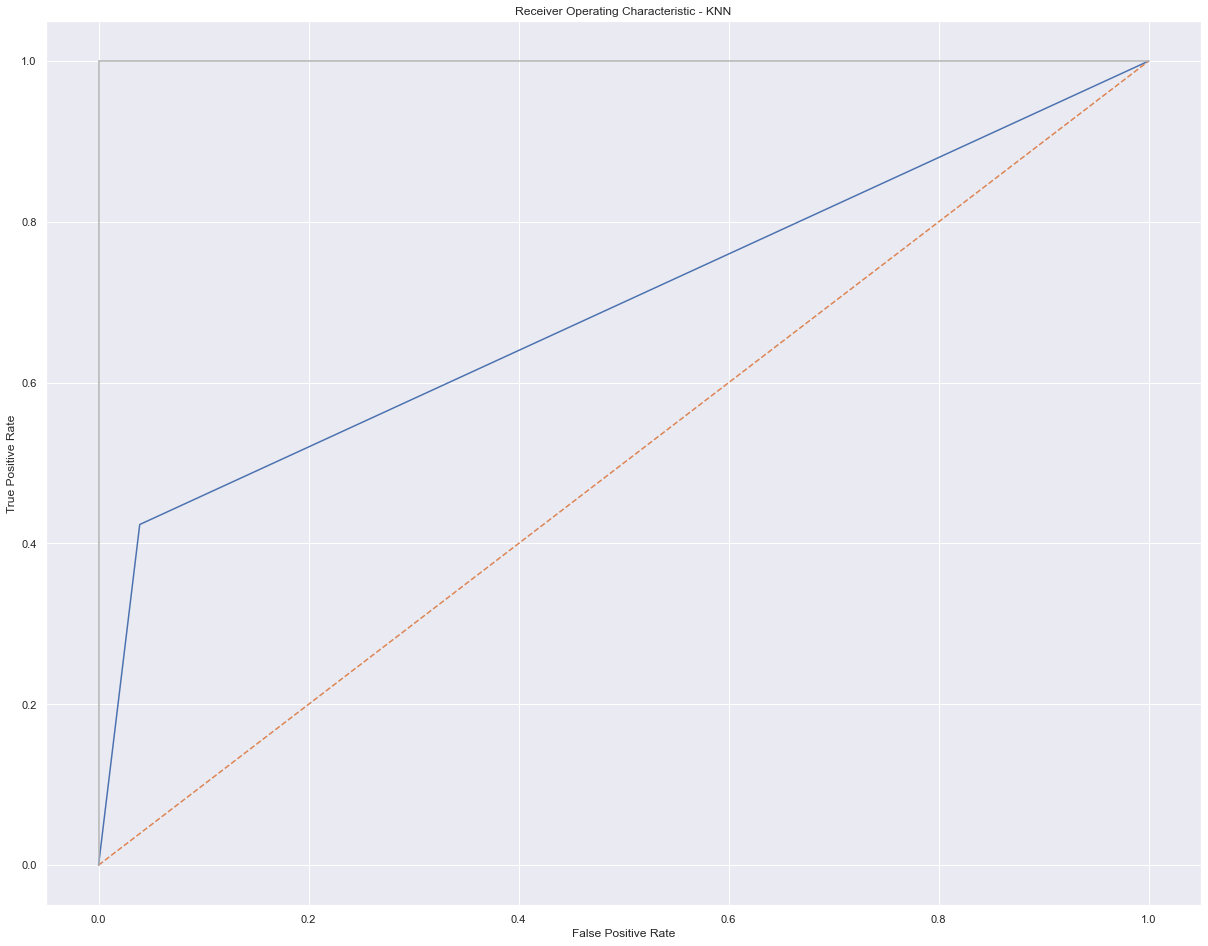

In [146]:
#AUC :
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model.predict(x_test), pos_label = 1)
print(false_positive_rate, true_positive_rate)
# 0.857142857143
print(roc_auc_score(y_test, model.predict(x_test)))
plt.title('Receiver Operating Characteristic - KNN')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [147]:
pd.crosstab(y_test, y_pred_test_KNN1, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0.0,1.0
Classe réelle,,
0.0,21232,866
1.0,3655,2686


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=434a662e-7efb-4fa9-b333-d41ab9a88069' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>